In [1]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
pd.set_option('display.max_columns', None) # 显示dataframe类型时 不限制columns标签显示
pd.set_option('display.max_rows', 100) # 显示dataframe类型时 不限制columns标签显示
pd.options.display.max_seq_items   = None # df.columns 显示不全


import warnings
warnings.filterwarnings("ignore")


# matplotlab 中文有乱码，所以要设置字体
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]
# 设置正常显示符号
mpl.rcParams["axes.unicode_minus"] = False


In [2]:
df = pd.read_csv('D:\\1my_learning\\1my_Academics\\CementKilnFiringSystem\\004_KilnCurr\\230425\\230423_data_长时间数据构造04.csv',
                 encoding = 'gbk',low_memory=False,parse_dates=['time'],index_col=['time'])

df.columns

Index(['喂料', '窑转速', '分解炉出口温度', '二次风温', '高温风机转速', '窑头罩压力', '56风机出口风压',
       'F1234平均流量', 'F56789平均流量', '窑电流', 'C1出口O2'],
      dtype='object')

In [3]:
data_MeanFiltered = df.copy()

########## 取滑动窗口均值

def MeanFilter(data, window_size):

    # 使用 rolling 和 mean 函数对数据进行滤波
    filtered_data = data.rolling(window_size, center=True).mean()

    # 返回滤波后的数据
    return filtered_data

# 滑动窗口均值
mean_window_size = 10

for i in data_MeanFiltered.columns:
    data_MeanFiltered[i]= MeanFilter(data_MeanFiltered[i],mean_window_size)


# fig,ax = plt.subplots(2,1,figsize=(18,10))
# s = 38400
# a = 400
# ax[0].plot(df['喂料'][s:s+a],c = 'k')
# ax[1].plot(data_MeanFiltered['喂料'][s:s+a])


In [4]:
##################################################
##########  返回模型输入数据
def Xdata(data,start_ts,end_ts):
    data_trainingset_list = data.loc[start_ts:end_ts,:]
    data_trainingset_list = data_trainingset_list.fillna(method='ffill').fillna(method='bfill')
    X = data_trainingset_list[inputs].values
    return X

##########  返回模型输出数据
def ydata(data,start_ts,end_ts):
    data_trainingset_list = data.loc[start_ts:end_ts,:]
    data_trainingset_list = data_trainingset_list.fillna(method='ffill').fillna(method='bfill')
    y = data_trainingset_list[outputs].values
    y = y.flatten()  
    return y

##########  返回岭回归模型
def RidgeRegressionModel(data,start_ts,end_ts , poly_degree = 2 , set_alpha=0.02):
    data_trainingset_list = data.loc[start_ts:end_ts,:]
    data_trainingset_list = data_trainingset_list.fillna(method='ffill').fillna(method='bfill')
    
    X = data_trainingset_list[inputs].values
    y = data_trainingset_list[outputs].values
    y = y.flatten()
    
    ploy = PolynomialFeatures(poly_degree)
    X_new = ploy.fit_transform(X)
    model = Ridge(alpha = set_alpha)
    model.fit(X_new, y)
    return model

##########  返回模型在某段时间上的MSE
def RidgeModelCheckMSE(model,data,current_time,back_check_window_size):
    X_check_model = Xdata(data,current_time - pd.Timedelta(minutes= back_check_window_size),current_time)
    y_check_model = ydata(data,current_time - pd.Timedelta(minutes= back_check_window_size),current_time)
    y_check_model_pred = model.predict(ploy.fit_transform(X_check_model))
    mse_check_model =float(mean_squared_error(y_check_model_pred , y_check_model))
    return mse_check_model


##########  挑选模型池中最好的模型
def choose_model(model_pool,data,time_now,MSE_check_size):
    for index, row in model_pool.iterrows():
        model = row['model']
        mse_check_model = RidgeModelCheckMSE(model,data1,time_now,MSE_check_size)
        model_pool.loc[index, 'MSE'] = mse_check_model
    model_pool['MSE'] = model_pool['MSE'].astype(float)
    best_model_index = model_pool['MSE'].idxmin()
    return model_pool.loc[best_model_index,'model'],time_now - pd.Timedelta(minutes= MSE_check_size),time_now


--------------- 2022-01-12 00:00:00 56

--------------- 2022-01-12 00:01:00 56

--------------- 2022-01-12 00:02:00 56

--------------- 2022-01-12 00:03:00 56

--------------- 2022-01-12 00:04:00 56

--------------- 2022-01-12 00:05:00 56

--------------- 2022-01-12 00:06:00 56

--------------- 2022-01-12 00:07:00 56

--------------- 2022-01-12 00:08:00 56

--------------- 2022-01-12 00:09:00 56

--------------- 2022-01-12 00:10:00 56

--------------- 2022-01-12 00:11:00 56

--------------- 2022-01-12 00:12:00 56

--------------- 2022-01-12 00:13:00 56

--------------- 2022-01-12 00:14:00 56

--------------- 2022-01-12 00:15:00 56

--------------- 2022-01-12 00:16:00 56

--------------- 2022-01-12 00:17:00 56

--------------- 2022-01-12 00:18:00 56

--------------- 2022-01-12 00:19:00 56

--------------- 2022-01-12 00:20:00 56

--------------- 2022-01-12 00:21:00 56

--------------- 2022-01-12 00:22:00 56

--------------- 2022-01-12 00:23:00 56

--------------- 2022-01-12 00:24:00 56



--------------- 2022-01-12 05:49:00 56

--------------- 2022-01-12 05:50:00 56

--------------- 2022-01-12 05:51:00 56

--------------- 2022-01-12 05:52:00 56

--------------- 2022-01-12 05:53:00 56

--------------- 2022-01-12 05:54:00 56

--------------- 2022-01-12 05:55:00 56

--------------- 2022-01-12 05:56:00 56

--------------- 2022-01-12 05:57:00 56

--------------- 2022-01-12 05:58:00 56

--------------- 2022-01-12 05:59:00 56

--------------- 2022-01-12 06:00:00 56

--------------- 2022-01-12 06:01:00 56

--------------- 2022-01-12 06:02:00 56

--------------- 2022-01-12 06:03:00 56

--------------- 2022-01-12 06:04:00 56

--------------- 2022-01-12 06:05:00 56

--------------- 2022-01-12 06:06:00 56

--------------- 2022-01-12 06:07:00 56

--------------- 2022-01-12 06:08:00 56

--------------- 2022-01-12 06:09:00 56

--------------- 2022-01-12 06:10:00 56

--------------- 2022-01-12 06:11:00 56

--------------- 2022-01-12 06:12:00 56

--------------- 2022-01-12 06:13:00 56



--------------- 2022-01-12 09:20:00 57

--------------- 2022-01-12 09:21:00 57

--------------- 2022-01-12 09:22:00 57

--------------- 2022-01-12 09:23:00 57

--------------- 2022-01-12 09:24:00 57

--------------- 2022-01-12 09:25:00 57

--------------- 2022-01-12 09:26:00 57

--------------- 2022-01-12 09:27:00 57

--------------- 2022-01-12 09:28:00 57

--------------- 2022-01-12 09:29:00 57

--------------- 2022-01-12 09:30:00 57

--------------- 2022-01-12 09:31:00 57

--------------- 2022-01-12 09:32:00 57

--------------- 2022-01-12 09:33:00 57

--------------- 2022-01-12 09:34:00 57

--------------- 2022-01-12 09:35:00 57

--------------- 2022-01-12 09:36:00 57

--------------- 2022-01-12 09:37:00 57

--------------- 2022-01-12 09:38:00 57

--------------- 2022-01-12 09:39:00 57

--------------- 2022-01-12 09:40:00 57

--------------- 2022-01-12 09:41:00 57

--------------- 2022-01-12 09:42:00 57

--------------- 2022-01-12 09:43:00 57

--------------- 2022-01-12 09:44:00 57



--------------- 2022-01-12 13:18:00 57

--------------- 2022-01-12 13:19:00 57

--------------- 2022-01-12 13:20:00 57

--------------- 2022-01-12 13:21:00 57

--------------- 2022-01-12 13:22:00 57

--------------- 2022-01-12 13:23:00 57

--------------- 2022-01-12 13:24:00 57

--------------- 2022-01-12 13:25:00 57

--------------- 2022-01-12 13:26:00 57

--------------- 2022-01-12 13:27:00 57

--------------- 2022-01-12 13:28:00 57

--------------- 2022-01-12 13:29:00 57

--------------- 2022-01-12 13:30:00 57

--------------- 2022-01-12 13:31:00 57

--------------- 2022-01-12 13:32:00 57

--------------- 2022-01-12 13:33:00 57

--------------- 2022-01-12 13:34:00 57

--------------- 2022-01-12 13:35:00 57

--------------- 2022-01-12 13:36:00 57

--------------- 2022-01-12 13:37:00 57

--------------- 2022-01-12 13:38:00 57

--------------- 2022-01-12 13:39:00 57

--------------- 2022-01-12 13:40:00 57

--------------- 2022-01-12 13:41:00 57

--------------- 2022-01-12 13:42:00 57



--------------- 2022-01-12 18:24:00 57

--------------- 2022-01-12 18:25:00 57

--------------- 2022-01-12 18:26:00 57

--------------- 2022-01-12 18:27:00 57

--------------- 2022-01-12 18:28:00 57

--------------- 2022-01-12 18:29:00 57

--------------- 2022-01-12 18:30:00 57

--------------- 2022-01-12 18:31:00 57

--------------- 2022-01-12 18:32:00 57

--------------- 2022-01-12 18:33:00 57

--------------- 2022-01-12 18:34:00 57

--------------- 2022-01-12 18:35:00 57

--------------- 2022-01-12 18:36:00 57

--------------- 2022-01-12 18:37:00 57

--------------- 2022-01-12 18:38:00 57

--------------- 2022-01-12 18:39:00 57

--------------- 2022-01-12 18:40:00 57

--------------- 2022-01-12 18:41:00 57

--------------- 2022-01-12 18:42:00 57

--------------- 2022-01-12 18:43:00 57

--------------- 2022-01-12 18:44:00 57

--------------- 2022-01-12 18:45:00 57

--------------- 2022-01-12 18:46:00 57

--------------- 2022-01-12 18:47:00 57

--------------- 2022-01-12 18:48:00 57



--------------- 2022-01-12 23:04:00 58

--------------- 2022-01-12 23:05:00 58

--------------- 2022-01-12 23:06:00 58

--------------- 2022-01-12 23:07:00 58

--------------- 2022-01-12 23:08:00 58

--------------- 2022-01-12 23:09:00 58

--------------- 2022-01-12 23:10:00 58

--------------- 2022-01-12 23:11:00 58

--------------- 2022-01-12 23:12:00 58

--------------- 2022-01-12 23:13:00 58

--------------- 2022-01-12 23:14:00 58

--------------- 2022-01-12 23:15:00 58

--------------- 2022-01-12 23:16:00 58

--------------- 2022-01-12 23:17:00 58

--------------- 2022-01-12 23:18:00 58

--------------- 2022-01-12 23:19:00 58

--------------- 2022-01-12 23:20:00 58

--------------- 2022-01-12 23:21:00 58

--------------- 2022-01-12 23:22:00 58

--------------- 2022-01-12 23:23:00 58

--------------- 2022-01-12 23:24:00 58

--------------- 2022-01-12 23:25:00 58

--------------- 2022-01-12 23:26:00 58

--------------- 2022-01-12 23:27:00 58

--------------- 2022-01-12 23:28:00 58



--------------- 2022-01-13 03:40:00 58

--------------- 2022-01-13 03:41:00 58

--------------- 2022-01-13 03:42:00 58

--------------- 2022-01-13 03:43:00 58

--------------- 2022-01-13 03:44:00 58

--------------- 2022-01-13 03:45:00 58

--------------- 2022-01-13 03:46:00 58

--------------- 2022-01-13 03:47:00 58

--------------- 2022-01-13 03:48:00 58

--------------- 2022-01-13 03:49:00 58

--------------- 2022-01-13 03:50:00 58

--------------- 2022-01-13 03:51:00 58

--------------- 2022-01-13 03:52:00 58

--------------- 2022-01-13 03:53:00 58

--------------- 2022-01-13 03:54:00 58

--------------- 2022-01-13 03:55:00 58

--------------- 2022-01-13 03:56:00 58

--------------- 2022-01-13 03:57:00 58

--------------- 2022-01-13 03:58:00 58

--------------- 2022-01-13 03:59:00 58

--------------- 2022-01-13 04:00:00 58

--------------- 2022-01-13 04:01:00 58

--------------- 2022-01-13 04:02:00 58

--------------- 2022-01-13 04:03:00 58

--------------- 2022-01-13 04:04:00 58



--------------- 2022-01-13 08:09:00 59

--------------- 2022-01-13 08:10:00 59

--------------- 2022-01-13 08:11:00 59

--------------- 2022-01-13 08:12:00 59

--------------- 2022-01-13 08:13:00 59

--------------- 2022-01-13 08:14:00 59

--------------- 2022-01-13 08:15:00 59

--------------- 2022-01-13 08:16:00 59

--------------- 2022-01-13 08:17:00 59

--------------- 2022-01-13 08:18:00 59

--------------- 2022-01-13 08:19:00 59

--------------- 2022-01-13 08:20:00 59

--------------- 2022-01-13 08:21:00 59

--------------- 2022-01-13 08:22:00 59

--------------- 2022-01-13 08:23:00 59

--------------- 2022-01-13 08:24:00 59

--------------- 2022-01-13 08:25:00 59

--------------- 2022-01-13 08:26:00 59

--------------- 2022-01-13 08:27:00 59

--------------- 2022-01-13 08:28:00 59

--------------- 2022-01-13 08:29:00 59

--------------- 2022-01-13 08:30:00 59

--------------- 2022-01-13 08:31:00 59

--------------- 2022-01-13 08:32:00 59

--------------- 2022-01-13 08:33:00 59



--------------- 2022-01-13 11:52:00 59

--------------- 2022-01-13 11:53:00 59

--------------- 2022-01-13 11:54:00 59

--------------- 2022-01-13 11:55:00 59

--------------- 2022-01-13 11:56:00 59

--------------- 2022-01-13 11:57:00 59

--------------- 2022-01-13 11:58:00 59

--------------- 2022-01-13 11:59:00 59

--------------- 2022-01-13 12:00:00 59

--------------- 2022-01-13 12:01:00 59

--------------- 2022-01-13 12:02:00 59

--------------- 2022-01-13 12:03:00 59

--------------- 2022-01-13 12:04:00 59

--------------- 2022-01-13 12:05:00 59

--------------- 2022-01-13 12:06:00 59

--------------- 2022-01-13 12:07:00 59

--------------- 2022-01-13 12:08:00 59

--------------- 2022-01-13 12:09:00 59

--------------- 2022-01-13 12:10:00 59

--------------- 2022-01-13 12:11:00 59

--------------- 2022-01-13 12:12:00 59

--------------- 2022-01-13 12:13:00 59

--------------- 2022-01-13 12:14:00 59

--------------- 2022-01-13 12:15:00 59

--------------- 2022-01-13 12:16:00 59



--------------- 2022-01-13 16:03:00 59

--------------- 2022-01-13 16:04:00 59

--------------- 2022-01-13 16:05:00 59

--------------- 2022-01-13 16:06:00 59

--------------- 2022-01-13 16:07:00 59

--------------- 2022-01-13 16:08:00 59

--------------- 2022-01-13 16:09:00 59

--------------- 2022-01-13 16:10:00 59

--------------- 2022-01-13 16:11:00 59

--------------- 2022-01-13 16:12:00 59

--------------- 2022-01-13 16:13:00 59

--------------- 2022-01-13 16:14:00 59

--------------- 2022-01-13 16:15:00 59

--------------- 2022-01-13 16:16:00 59

--------------- 2022-01-13 16:17:00 59

--------------- 2022-01-13 16:18:00 59

--------------- 2022-01-13 16:19:00 59

--------------- 2022-01-13 16:20:00 59

--------------- 2022-01-13 16:21:00 59

--------------- 2022-01-13 16:22:00 59

--------------- 2022-01-13 16:23:00 59

--------------- 2022-01-13 16:24:00 59

--------------- 2022-01-13 16:25:00 59

--------------- 2022-01-13 16:26:00 59

--------------- 2022-01-13 16:27:00 59



--------------- 2022-01-13 20:37:00 59

--------------- 2022-01-13 20:38:00 59

--------------- 2022-01-13 20:39:00 59

--------------- 2022-01-13 20:40:00 59

--------------- 2022-01-13 20:41:00 59

--------------- 2022-01-13 20:42:00 59

--------------- 2022-01-13 20:43:00 59

--------------- 2022-01-13 20:44:00 59

--------------- 2022-01-13 20:45:00 59

--------------- 2022-01-13 20:46:00 59

--------------- 2022-01-13 20:47:00 59

--------------- 2022-01-13 20:48:00 59

--------------- 2022-01-13 20:49:00 59

--------------- 2022-01-13 20:50:00 59

--------------- 2022-01-13 20:51:00 59

--------------- 2022-01-13 20:52:00 59

--------------- 2022-01-13 20:53:00 59

--------------- 2022-01-13 20:54:00 59

--------------- 2022-01-13 20:55:00 59

--------------- 2022-01-13 20:56:00 59

--------------- 2022-01-13 20:57:00 59

--------------- 2022-01-13 20:58:00 59

--------------- 2022-01-13 20:59:00 59

--------------- 2022-01-13 21:00:00 59

--------------- 2022-01-13 21:01:00 59



--------------- 2022-01-14 00:09:00 59

--------------- 2022-01-14 00:10:00 59

--------------- 2022-01-14 00:11:00 59

--------------- 2022-01-14 00:12:00 59

--------------- 2022-01-14 00:13:00 59

--------------- 2022-01-14 00:14:00 59

--------------- 2022-01-14 00:15:00 59

--------------- 2022-01-14 00:16:00 59

--------------- 2022-01-14 00:17:00 59

--------------- 2022-01-14 00:18:00 59

--------------- 2022-01-14 00:19:00 59

--------------- 2022-01-14 00:20:00 59

--------------- 2022-01-14 00:21:00 59

--------------- 2022-01-14 00:22:00 59

--------------- 2022-01-14 00:23:00 59

--------------- 2022-01-14 00:24:00 59

--------------- 2022-01-14 00:25:00 59

--------------- 2022-01-14 00:26:00 59

--------------- 2022-01-14 00:27:00 59

--------------- 2022-01-14 00:28:00 59

--------------- 2022-01-14 00:29:00 59

--------------- 2022-01-14 00:30:00 59

--------------- 2022-01-14 00:31:00 59

--------------- 2022-01-14 00:32:00 59

--------------- 2022-01-14 00:33:00 59



--------------- 2022-01-14 09:13:00 59

--------------- 2022-01-14 09:14:00 59

--------------- 2022-01-14 09:15:00 59

--------------- 2022-01-14 09:16:00 59

--------------- 2022-01-14 09:17:00 59

--------------- 2022-01-14 09:18:00 59

--------------- 2022-01-14 09:19:00 59

--------------- 2022-01-14 09:20:00 59

--------------- 2022-01-14 09:21:00 59

--------------- 2022-01-14 09:22:00 59

--------------- 2022-01-14 09:23:00 59

--------------- 2022-01-14 09:24:00 59

--------------- 2022-01-14 09:25:00 59

--------------- 2022-01-14 09:26:00 59

--------------- 2022-01-14 09:27:00 59

--------------- 2022-01-14 09:28:00 59

--------------- 2022-01-14 09:29:00 59

--------------- 2022-01-14 09:30:00 59

--------------- 2022-01-14 09:31:00 59

--------------- 2022-01-14 09:32:00 59

--------------- 2022-01-14 09:33:00 59

--------------- 2022-01-14 09:34:00 59

--------------- 2022-01-14 09:35:00 59

--------------- 2022-01-14 09:36:00 59

--------------- 2022-01-14 09:37:00 59



--------------- 2022-01-14 13:12:00 59

--------------- 2022-01-14 13:13:00 59

--------------- 2022-01-14 13:14:00 59

--------------- 2022-01-14 13:15:00 59

--------------- 2022-01-14 13:16:00 59

--------------- 2022-01-14 13:17:00 59

--------------- 2022-01-14 13:18:00 59

--------------- 2022-01-14 13:19:00 59

--------------- 2022-01-14 13:20:00 59

--------------- 2022-01-14 13:21:00 59

--------------- 2022-01-14 13:22:00 59

--------------- 2022-01-14 13:23:00 59

--------------- 2022-01-14 13:24:00 59

--------------- 2022-01-14 13:25:00 59

--------------- 2022-01-14 13:26:00 59

--------------- 2022-01-14 13:27:00 59

--------------- 2022-01-14 13:28:00 59

--------------- 2022-01-14 13:29:00 59

--------------- 2022-01-14 13:30:00 59

--------------- 2022-01-14 13:31:00 59

--------------- 2022-01-14 13:32:00 59

--------------- 2022-01-14 13:33:00 59

--------------- 2022-01-14 13:34:00 59

--------------- 2022-01-14 13:35:00 59

--------------- 2022-01-14 13:36:00 59



--------------- 2022-01-14 18:10:00 59

--------------- 2022-01-14 18:11:00 59

--------------- 2022-01-14 18:12:00 59

--------------- 2022-01-14 18:13:00 59

--------------- 2022-01-14 18:14:00 59

--------------- 2022-01-14 18:15:00 59

--------------- 2022-01-14 18:16:00 59

--------------- 2022-01-14 18:17:00 59

--------------- 2022-01-14 18:18:00 59

--------------- 2022-01-14 18:19:00 59

--------------- 2022-01-14 18:20:00 59

--------------- 2022-01-14 18:21:00 59

--------------- 2022-01-14 18:22:00 59

--------------- 2022-01-14 18:23:00 59

--------------- 2022-01-14 18:24:00 59

--------------- 2022-01-14 18:25:00 59

--------------- 2022-01-14 18:26:00 59

--------------- 2022-01-14 18:27:00 59

--------------- 2022-01-14 18:28:00 59

--------------- 2022-01-14 18:29:00 59

--------------- 2022-01-14 18:30:00 59

--------------- 2022-01-14 18:31:00 59

--------------- 2022-01-14 18:32:00 59

--------------- 2022-01-14 18:33:00 59

--------------- 2022-01-14 18:34:00 59



--------------- 2022-01-15 00:13:00 59

--------------- 2022-01-15 00:14:00 59

--------------- 2022-01-15 00:15:00 59

--------------- 2022-01-15 00:16:00 59

--------------- 2022-01-15 00:17:00 59

--------------- 2022-01-15 00:18:00 59

--------------- 2022-01-15 00:19:00 59

--------------- 2022-01-15 00:20:00 59

--------------- 2022-01-15 00:21:00 59

--------------- 2022-01-15 00:22:00 59

--------------- 2022-01-15 00:23:00 59

--------------- 2022-01-15 00:24:00 59

--------------- 2022-01-15 00:25:00 59

--------------- 2022-01-15 00:26:00 59

--------------- 2022-01-15 00:27:00 59

--------------- 2022-01-15 00:28:00 59

--------------- 2022-01-15 00:29:00 59

--------------- 2022-01-15 00:30:00 59

--------------- 2022-01-15 00:31:00 59

--------------- 2022-01-15 00:32:00 59

--------------- 2022-01-15 00:33:00 60

--------------- 2022-01-15 00:34:00 60

--------------- 2022-01-15 00:35:00 60

--------------- 2022-01-15 00:36:00 60

--------------- 2022-01-15 00:37:00 60



--------------- 2022-01-15 04:41:00 60

--------------- 2022-01-15 04:42:00 60

--------------- 2022-01-15 04:43:00 60

--------------- 2022-01-15 04:44:00 60

--------------- 2022-01-15 04:45:00 60

--------------- 2022-01-15 04:46:00 60

--------------- 2022-01-15 04:47:00 60

--------------- 2022-01-15 04:48:00 60

--------------- 2022-01-15 04:49:00 60

--------------- 2022-01-15 04:50:00 60

--------------- 2022-01-15 04:51:00 60

--------------- 2022-01-15 04:52:00 60

--------------- 2022-01-15 04:53:00 60

--------------- 2022-01-15 04:54:00 60

--------------- 2022-01-15 04:55:00 60

--------------- 2022-01-15 04:56:00 60

--------------- 2022-01-15 04:57:00 60

--------------- 2022-01-15 04:58:00 60

--------------- 2022-01-15 04:59:00 60

--------------- 2022-01-15 05:00:00 60

--------------- 2022-01-15 05:01:00 60

--------------- 2022-01-15 05:02:00 60

--------------- 2022-01-15 05:03:00 60

--------------- 2022-01-15 05:04:00 60

--------------- 2022-01-15 05:05:00 60



--------------- 2022-01-15 08:21:00 60

--------------- 2022-01-15 08:22:00 60

--------------- 2022-01-15 08:23:00 60

--------------- 2022-01-15 08:24:00 60

--------------- 2022-01-15 08:25:00 60

--------------- 2022-01-15 08:26:00 60

--------------- 2022-01-15 08:27:00 60

--------------- 2022-01-15 08:28:00 60

--------------- 2022-01-15 08:29:00 60

--------------- 2022-01-15 08:30:00 60

--------------- 2022-01-15 08:31:00 60

--------------- 2022-01-15 08:32:00 60

--------------- 2022-01-15 08:33:00 60

--------------- 2022-01-15 08:34:00 60

--------------- 2022-01-15 08:35:00 60

--------------- 2022-01-15 08:36:00 60

--------------- 2022-01-15 08:37:00 60

--------------- 2022-01-15 08:38:00 60

--------------- 2022-01-15 08:39:00 60

--------------- 2022-01-15 08:40:00 60

--------------- 2022-01-15 08:41:00 60

--------------- 2022-01-15 08:42:00 60

--------------- 2022-01-15 08:43:00 60

--------------- 2022-01-15 08:44:00 60

--------------- 2022-01-15 08:45:00 60



--------------- 2022-01-15 12:35:00 60

--------------- 2022-01-15 12:36:00 60

--------------- 2022-01-15 12:37:00 60

--------------- 2022-01-15 12:38:00 60

--------------- 2022-01-15 12:39:00 60

--------------- 2022-01-15 12:40:00 60

--------------- 2022-01-15 12:41:00 60

--------------- 2022-01-15 12:42:00 60

--------------- 2022-01-15 12:43:00 60

--------------- 2022-01-15 12:44:00 60

--------------- 2022-01-15 12:45:00 60

--------------- 2022-01-15 12:46:00 60

--------------- 2022-01-15 12:47:00 60

--------------- 2022-01-15 12:48:00 60

--------------- 2022-01-15 12:49:00 60

--------------- 2022-01-15 12:50:00 60

--------------- 2022-01-15 12:51:00 60

--------------- 2022-01-15 12:52:00 60

--------------- 2022-01-15 12:53:00 60

--------------- 2022-01-15 12:54:00 60

--------------- 2022-01-15 12:55:00 60

--------------- 2022-01-15 12:56:00 60

--------------- 2022-01-15 12:57:00 60

--------------- 2022-01-15 12:58:00 60

--------------- 2022-01-15 12:59:00 60



--------------- 2022-01-15 16:24:00 61

--------------- 2022-01-15 16:25:00 61

--------------- 2022-01-15 16:26:00 61

--------------- 2022-01-15 16:27:00 61

--------------- 2022-01-15 16:28:00 61

--------------- 2022-01-15 16:29:00 61

--------------- 2022-01-15 16:30:00 61

--------------- 2022-01-15 16:31:00 61

--------------- 2022-01-15 16:32:00 61

--------------- 2022-01-15 16:33:00 61

--------------- 2022-01-15 16:34:00 61

--------------- 2022-01-15 16:35:00 61

--------------- 2022-01-15 16:36:00 61

--------------- 2022-01-15 16:37:00 61

--------------- 2022-01-15 16:38:00 61

--------------- 2022-01-15 16:39:00 61

--------------- 2022-01-15 16:40:00 61

--------------- 2022-01-15 16:41:00 61

--------------- 2022-01-15 16:42:00 61

--------------- 2022-01-15 16:43:00 61

--------------- 2022-01-15 16:44:00 62

--------------- 2022-01-15 16:45:00 62

--------------- 2022-01-15 16:46:00 62

--------------- 2022-01-15 16:47:00 62

--------------- 2022-01-15 16:48:00 62



--------------- 2022-01-15 21:29:00 62

--------------- 2022-01-15 21:30:00 62

--------------- 2022-01-15 21:31:00 62

--------------- 2022-01-15 21:32:00 62

--------------- 2022-01-15 21:33:00 62

--------------- 2022-01-15 21:34:00 62

--------------- 2022-01-15 21:35:00 62

--------------- 2022-01-15 21:36:00 62

--------------- 2022-01-15 21:37:00 62

--------------- 2022-01-15 21:38:00 62

--------------- 2022-01-15 21:39:00 62

--------------- 2022-01-15 21:40:00 62

--------------- 2022-01-15 21:41:00 62

--------------- 2022-01-15 21:42:00 62

--------------- 2022-01-15 21:43:00 62

--------------- 2022-01-15 21:44:00 62

--------------- 2022-01-15 21:45:00 62

--------------- 2022-01-15 21:46:00 62

--------------- 2022-01-15 21:47:00 62

--------------- 2022-01-15 21:48:00 62

--------------- 2022-01-15 21:49:00 62

--------------- 2022-01-15 21:50:00 62

--------------- 2022-01-15 21:51:00 62

--------------- 2022-01-15 21:52:00 62

--------------- 2022-01-15 21:53:00 62



--------------- 2022-01-16 02:35:00 63

--------------- 2022-01-16 02:36:00 63

--------------- 2022-01-16 02:37:00 63

--------------- 2022-01-16 02:38:00 63

--------------- 2022-01-16 02:39:00 63

--------------- 2022-01-16 02:40:00 63

--------------- 2022-01-16 02:41:00 63

--------------- 2022-01-16 02:42:00 63

--------------- 2022-01-16 02:43:00 63

--------------- 2022-01-16 02:44:00 63

--------------- 2022-01-16 02:45:00 63

--------------- 2022-01-16 02:46:00 63

--------------- 2022-01-16 02:47:00 63

--------------- 2022-01-16 02:48:00 63

--------------- 2022-01-16 02:49:00 63

--------------- 2022-01-16 02:50:00 63

--------------- 2022-01-16 02:51:00 63

--------------- 2022-01-16 02:52:00 63

--------------- 2022-01-16 02:53:00 63

--------------- 2022-01-16 02:54:00 63

--------------- 2022-01-16 02:55:00 63

--------------- 2022-01-16 02:56:00 63

--------------- 2022-01-16 02:57:00 63

--------------- 2022-01-16 02:58:00 63

--------------- 2022-01-16 02:59:00 63



--------------- 2022-01-16 06:19:00 63

--------------- 2022-01-16 06:20:00 63

--------------- 2022-01-16 06:21:00 63

--------------- 2022-01-16 06:22:00 63

--------------- 2022-01-16 06:23:00 63

--------------- 2022-01-16 06:24:00 63

--------------- 2022-01-16 06:25:00 63

--------------- 2022-01-16 06:26:00 63

--------------- 2022-01-16 06:27:00 63

--------------- 2022-01-16 06:28:00 63

--------------- 2022-01-16 06:29:00 63

--------------- 2022-01-16 06:30:00 63

--------------- 2022-01-16 06:31:00 63

--------------- 2022-01-16 06:32:00 63

--------------- 2022-01-16 06:33:00 63

--------------- 2022-01-16 06:34:00 63

--------------- 2022-01-16 06:35:00 63

--------------- 2022-01-16 06:36:00 63

--------------- 2022-01-16 06:37:00 63

--------------- 2022-01-16 06:38:00 63

--------------- 2022-01-16 06:39:00 63

--------------- 2022-01-16 06:40:00 63

--------------- 2022-01-16 06:41:00 63

--------------- 2022-01-16 06:42:00 63

--------------- 2022-01-16 06:43:00 63



--------------- 2022-01-16 10:14:00 64

--------------- 2022-01-16 10:15:00 64

--------------- 2022-01-16 10:16:00 64

--------------- 2022-01-16 10:17:00 64

--------------- 2022-01-16 10:18:00 64

--------------- 2022-01-16 10:19:00 64

--------------- 2022-01-16 10:20:00 64

--------------- 2022-01-16 10:21:00 64

--------------- 2022-01-16 10:22:00 64

--------------- 2022-01-16 10:23:00 64

--------------- 2022-01-16 10:24:00 64

--------------- 2022-01-16 10:25:00 64

--------------- 2022-01-16 10:26:00 64

--------------- 2022-01-16 10:27:00 64

--------------- 2022-01-16 10:28:00 64

--------------- 2022-01-16 10:29:00 64

--------------- 2022-01-16 10:30:00 64

--------------- 2022-01-16 10:31:00 64

--------------- 2022-01-16 10:32:00 64

--------------- 2022-01-16 10:33:00 64

--------------- 2022-01-16 10:34:00 64

--------------- 2022-01-16 10:35:00 64

--------------- 2022-01-16 10:36:00 64

--------------- 2022-01-16 10:37:00 64

--------------- 2022-01-16 10:38:00 64



--------------- 2022-01-16 13:55:00 64

--------------- 2022-01-16 13:56:00 64

--------------- 2022-01-16 13:57:00 64

--------------- 2022-01-16 13:58:00 64

--------------- 2022-01-16 13:59:00 64

--------------- 2022-01-16 14:00:00 64

--------------- 2022-01-16 14:01:00 64

--------------- 2022-01-16 14:02:00 64

--------------- 2022-01-16 14:03:00 64

--------------- 2022-01-16 14:04:00 64

--------------- 2022-01-16 14:05:00 64

--------------- 2022-01-16 14:06:00 64

--------------- 2022-01-16 14:07:00 64

--------------- 2022-01-16 14:08:00 64

--------------- 2022-01-16 14:09:00 64

--------------- 2022-01-16 14:10:00 64

--------------- 2022-01-16 14:11:00 64

--------------- 2022-01-16 14:12:00 64

--------------- 2022-01-16 14:13:00 64

--------------- 2022-01-16 14:14:00 64

--------------- 2022-01-16 14:15:00 64

--------------- 2022-01-16 14:16:00 64

--------------- 2022-01-16 14:17:00 64

--------------- 2022-01-16 14:18:00 64

--------------- 2022-01-16 14:19:00 64



--------------- 2022-01-16 17:23:00 64

--------------- 2022-01-16 17:24:00 64

--------------- 2022-01-16 17:25:00 64

--------------- 2022-01-16 17:26:00 64

--------------- 2022-01-16 17:27:00 64

--------------- 2022-01-16 17:28:00 64

--------------- 2022-01-16 17:29:00 64

--------------- 2022-01-16 17:30:00 64

--------------- 2022-01-16 17:31:00 64

--------------- 2022-01-16 17:32:00 64

--------------- 2022-01-16 17:33:00 64

--------------- 2022-01-16 17:34:00 64

--------------- 2022-01-16 17:35:00 64

--------------- 2022-01-16 17:36:00 64

--------------- 2022-01-16 17:37:00 64

--------------- 2022-01-16 17:38:00 64

--------------- 2022-01-16 17:39:00 64

--------------- 2022-01-16 17:40:00 64

--------------- 2022-01-16 17:41:00 64

--------------- 2022-01-16 17:42:00 64

--------------- 2022-01-16 17:43:00 64

--------------- 2022-01-16 17:44:00 64

--------------- 2022-01-16 17:45:00 64

--------------- 2022-01-16 17:46:00 64

--------------- 2022-01-16 17:47:00 64



--------------- 2022-01-16 20:52:00 64

--------------- 2022-01-16 20:53:00 64

--------------- 2022-01-16 20:54:00 64

--------------- 2022-01-16 20:55:00 64

--------------- 2022-01-16 20:56:00 64

--------------- 2022-01-16 20:57:00 64

--------------- 2022-01-16 20:58:00 64

--------------- 2022-01-16 20:59:00 64

--------------- 2022-01-16 21:00:00 64

--------------- 2022-01-16 21:01:00 64

--------------- 2022-01-16 21:02:00 64

--------------- 2022-01-16 21:03:00 64

--------------- 2022-01-16 21:04:00 64

--------------- 2022-01-16 21:05:00 64

--------------- 2022-01-16 21:06:00 64

--------------- 2022-01-16 21:07:00 64

--------------- 2022-01-16 21:08:00 64

--------------- 2022-01-16 21:09:00 64

--------------- 2022-01-16 21:10:00 64

--------------- 2022-01-16 21:11:00 64

--------------- 2022-01-16 21:12:00 64

--------------- 2022-01-16 21:13:00 64

--------------- 2022-01-16 21:14:00 64

--------------- 2022-01-16 21:15:00 64

--------------- 2022-01-16 21:16:00 64



--------------- 2022-01-17 00:26:00 64

--------------- 2022-01-17 00:27:00 64

--------------- 2022-01-17 00:28:00 64

--------------- 2022-01-17 00:29:00 64

--------------- 2022-01-17 00:30:00 64

--------------- 2022-01-17 00:31:00 64

--------------- 2022-01-17 00:32:00 64

--------------- 2022-01-17 00:33:00 64

--------------- 2022-01-17 00:34:00 64

--------------- 2022-01-17 00:35:00 64

--------------- 2022-01-17 00:36:00 64

--------------- 2022-01-17 00:37:00 64

--------------- 2022-01-17 00:38:00 64

--------------- 2022-01-17 00:39:00 64

--------------- 2022-01-17 00:40:00 64

--------------- 2022-01-17 00:41:00 64

--------------- 2022-01-17 00:42:00 64

--------------- 2022-01-17 00:43:00 64

--------------- 2022-01-17 00:44:00 64

--------------- 2022-01-17 00:45:00 64

--------------- 2022-01-17 00:46:00 64

--------------- 2022-01-17 00:47:00 64

--------------- 2022-01-17 00:48:00 64

--------------- 2022-01-17 00:49:00 64

--------------- 2022-01-17 00:50:00 64



--------------- 2022-01-17 04:34:00 64

--------------- 2022-01-17 04:35:00 64

--------------- 2022-01-17 04:36:00 64

--------------- 2022-01-17 04:37:00 64

--------------- 2022-01-17 04:38:00 64

--------------- 2022-01-17 04:39:00 64

--------------- 2022-01-17 04:40:00 64

--------------- 2022-01-17 04:41:00 64

--------------- 2022-01-17 04:42:00 64

--------------- 2022-01-17 04:43:00 64

--------------- 2022-01-17 04:44:00 64

--------------- 2022-01-17 04:45:00 64

--------------- 2022-01-17 04:46:00 64

--------------- 2022-01-17 04:47:00 64

--------------- 2022-01-17 04:48:00 64

--------------- 2022-01-17 04:49:00 64

--------------- 2022-01-17 04:50:00 64

--------------- 2022-01-17 04:51:00 64

--------------- 2022-01-17 04:52:00 64

--------------- 2022-01-17 04:53:00 64

--------------- 2022-01-17 04:54:00 64

--------------- 2022-01-17 04:55:00 64

--------------- 2022-01-17 04:56:00 64

--------------- 2022-01-17 04:57:00 64

--------------- 2022-01-17 04:58:00 64



--------------- 2022-01-17 09:30:00 64

--------------- 2022-01-17 09:31:00 64

--------------- 2022-01-17 09:32:00 64

--------------- 2022-01-17 09:33:00 64

--------------- 2022-01-17 09:34:00 64

--------------- 2022-01-17 09:35:00 64

--------------- 2022-01-17 09:36:00 64

--------------- 2022-01-17 09:37:00 64

--------------- 2022-01-17 09:38:00 64

--------------- 2022-01-17 09:39:00 64

--------------- 2022-01-17 09:40:00 64

--------------- 2022-01-17 09:41:00 64

--------------- 2022-01-17 09:42:00 64

--------------- 2022-01-17 09:43:00 64

--------------- 2022-01-17 09:44:00 64

--------------- 2022-01-17 09:45:00 64

--------------- 2022-01-17 09:46:00 64

--------------- 2022-01-17 09:47:00 64

--------------- 2022-01-17 09:48:00 64

--------------- 2022-01-17 09:49:00 64

--------------- 2022-01-17 09:50:00 64

--------------- 2022-01-17 09:51:00 64

--------------- 2022-01-17 09:52:00 64

--------------- 2022-01-17 09:53:00 64

--------------- 2022-01-17 09:54:00 64



--------------- 2022-01-17 14:38:00 64

--------------- 2022-01-17 14:39:00 64

--------------- 2022-01-17 14:40:00 64

--------------- 2022-01-17 14:41:00 64

--------------- 2022-01-17 14:42:00 64

--------------- 2022-01-17 14:43:00 64

--------------- 2022-01-17 14:44:00 64

--------------- 2022-01-17 14:45:00 64

--------------- 2022-01-17 14:46:00 64

--------------- 2022-01-17 14:47:00 64

--------------- 2022-01-17 14:48:00 64

--------------- 2022-01-17 14:49:00 64

--------------- 2022-01-17 14:50:00 64

--------------- 2022-01-17 14:51:00 64

--------------- 2022-01-17 14:52:00 64

--------------- 2022-01-17 14:53:00 64

--------------- 2022-01-17 14:54:00 64

--------------- 2022-01-17 14:55:00 64

--------------- 2022-01-17 14:56:00 64

--------------- 2022-01-17 14:57:00 64

--------------- 2022-01-17 14:58:00 64

--------------- 2022-01-17 14:59:00 64

--------------- 2022-01-17 15:00:00 64

--------------- 2022-01-17 15:01:00 64

--------------- 2022-01-17 15:02:00 64



--------------- 2022-01-17 21:47:00 64

--------------- 2022-01-17 21:48:00 64

--------------- 2022-01-17 21:49:00 64

--------------- 2022-01-17 21:50:00 64

--------------- 2022-01-17 21:51:00 64

--------------- 2022-01-17 21:52:00 64

--------------- 2022-01-17 21:53:00 64

--------------- 2022-01-17 21:54:00 64

--------------- 2022-01-17 21:55:00 64

--------------- 2022-01-17 21:56:00 64

--------------- 2022-01-17 21:57:00 64

--------------- 2022-01-17 21:58:00 64

--------------- 2022-01-17 21:59:00 64

--------------- 2022-01-17 22:00:00 64

--------------- 2022-01-17 22:01:00 64

--------------- 2022-01-17 22:02:00 64

--------------- 2022-01-17 22:03:00 64

--------------- 2022-01-17 22:04:00 64

--------------- 2022-01-17 22:05:00 64

--------------- 2022-01-17 22:06:00 64

--------------- 2022-01-17 22:07:00 64

--------------- 2022-01-17 22:08:00 64

--------------- 2022-01-17 22:09:00 64

--------------- 2022-01-17 22:10:00 64

--------------- 2022-01-17 22:11:00 64



--------------- 2022-01-18 01:16:00 65

--------------- 2022-01-18 01:17:00 65

--------------- 2022-01-18 01:18:00 65

--------------- 2022-01-18 01:19:00 65

--------------- 2022-01-18 01:20:00 65

--------------- 2022-01-18 01:21:00 65

--------------- 2022-01-18 01:22:00 65

--------------- 2022-01-18 01:23:00 65

--------------- 2022-01-18 01:24:00 65

--------------- 2022-01-18 01:25:00 65

--------------- 2022-01-18 01:26:00 65

--------------- 2022-01-18 01:27:00 65

--------------- 2022-01-18 01:28:00 65

--------------- 2022-01-18 01:29:00 65

--------------- 2022-01-18 01:30:00 65

--------------- 2022-01-18 01:31:00 65

--------------- 2022-01-18 01:32:00 65

--------------- 2022-01-18 01:33:00 65

--------------- 2022-01-18 01:34:00 65

--------------- 2022-01-18 01:35:00 65

--------------- 2022-01-18 01:36:00 66

--------------- 2022-01-18 01:37:00 66

--------------- 2022-01-18 01:38:00 66

--------------- 2022-01-18 01:39:00 66

--------------- 2022-01-18 01:40:00 66



--------------- 2022-01-18 05:19:00 67

--------------- 2022-01-18 05:20:00 67

--------------- 2022-01-18 05:21:00 67

--------------- 2022-01-18 05:22:00 67

--------------- 2022-01-18 05:23:00 67

--------------- 2022-01-18 05:24:00 67

--------------- 2022-01-18 05:25:00 67

--------------- 2022-01-18 05:26:00 67

--------------- 2022-01-18 05:27:00 67

--------------- 2022-01-18 05:28:00 67

--------------- 2022-01-18 05:29:00 67

--------------- 2022-01-18 05:30:00 67

--------------- 2022-01-18 05:31:00 67

--------------- 2022-01-18 05:32:00 67

--------------- 2022-01-18 05:33:00 67

--------------- 2022-01-18 05:34:00 67

--------------- 2022-01-18 05:35:00 67

--------------- 2022-01-18 05:36:00 67

--------------- 2022-01-18 05:37:00 67

--------------- 2022-01-18 05:38:00 67

--------------- 2022-01-18 05:39:00 67

--------------- 2022-01-18 05:40:00 67

--------------- 2022-01-18 05:41:00 67

--------------- 2022-01-18 05:42:00 67

--------------- 2022-01-18 05:43:00 67



--------------- 2022-01-18 10:04:00 67

--------------- 2022-01-18 10:05:00 67

--------------- 2022-01-18 10:06:00 67

--------------- 2022-01-18 10:07:00 67

--------------- 2022-01-18 10:08:00 67

--------------- 2022-01-18 10:09:00 67

--------------- 2022-01-18 10:10:00 67

--------------- 2022-01-18 10:11:00 67

--------------- 2022-01-18 10:12:00 67

--------------- 2022-01-18 10:13:00 67

--------------- 2022-01-18 10:14:00 67

--------------- 2022-01-18 10:15:00 67

--------------- 2022-01-18 10:16:00 67

--------------- 2022-01-18 10:17:00 67

--------------- 2022-01-18 10:18:00 67

--------------- 2022-01-18 10:19:00 67

--------------- 2022-01-18 10:20:00 67

--------------- 2022-01-18 10:21:00 67

--------------- 2022-01-18 10:22:00 67

--------------- 2022-01-18 10:23:00 67

--------------- 2022-01-18 10:24:00 67

--------------- 2022-01-18 10:25:00 67

--------------- 2022-01-18 10:26:00 67

--------------- 2022-01-18 10:27:00 67

--------------- 2022-01-18 10:28:00 67



--------------- 2022-01-18 14:34:00 70

--------------- 2022-01-18 14:35:00 70

--------------- 2022-01-18 14:36:00 70

--------------- 2022-01-18 14:37:00 70

--------------- 2022-01-18 14:38:00 70

--------------- 2022-01-18 14:39:00 70

--------------- 2022-01-18 14:40:00 70

--------------- 2022-01-18 14:41:00 70

--------------- 2022-01-18 14:42:00 70

--------------- 2022-01-18 14:43:00 70

--------------- 2022-01-18 14:44:00 70

--------------- 2022-01-18 14:45:00 70

--------------- 2022-01-18 14:46:00 70

--------------- 2022-01-18 14:47:00 70

--------------- 2022-01-18 14:48:00 70

--------------- 2022-01-18 14:49:00 70

--------------- 2022-01-18 14:50:00 70

--------------- 2022-01-18 14:51:00 70

--------------- 2022-01-18 14:52:00 70

--------------- 2022-01-18 14:53:00 70

--------------- 2022-01-18 14:54:00 71

--------------- 2022-01-18 14:55:00 71

--------------- 2022-01-18 14:56:00 71

--------------- 2022-01-18 14:57:00 71

--------------- 2022-01-18 14:58:00 71



--------------- 2022-01-18 18:41:00 72

--------------- 2022-01-18 18:42:00 72

--------------- 2022-01-18 18:43:00 72

--------------- 2022-01-18 18:44:00 72

--------------- 2022-01-18 18:45:00 72

--------------- 2022-01-18 18:46:00 72

--------------- 2022-01-18 18:47:00 72

--------------- 2022-01-18 18:48:00 72

--------------- 2022-01-18 18:49:00 72

--------------- 2022-01-18 18:50:00 72

--------------- 2022-01-18 18:51:00 72

--------------- 2022-01-18 18:52:00 72

--------------- 2022-01-18 18:53:00 72

--------------- 2022-01-18 18:54:00 72

--------------- 2022-01-18 18:55:00 72

--------------- 2022-01-18 18:56:00 72

--------------- 2022-01-18 18:57:00 72

--------------- 2022-01-18 18:58:00 72

--------------- 2022-01-18 18:59:00 72

--------------- 2022-01-18 19:00:00 72

--------------- 2022-01-18 19:01:00 73

--------------- 2022-01-18 19:02:00 73

--------------- 2022-01-18 19:03:00 73

--------------- 2022-01-18 19:04:00 73

--------------- 2022-01-18 19:05:00 73



--------------- 2022-01-18 22:35:00 73

--------------- 2022-01-18 22:36:00 73

--------------- 2022-01-18 22:37:00 73

--------------- 2022-01-18 22:38:00 73

--------------- 2022-01-18 22:39:00 73

--------------- 2022-01-18 22:40:00 73

--------------- 2022-01-18 22:41:00 73

--------------- 2022-01-18 22:42:00 73

--------------- 2022-01-18 22:43:00 73

--------------- 2022-01-18 22:44:00 73

--------------- 2022-01-18 22:45:00 73

--------------- 2022-01-18 22:46:00 73

--------------- 2022-01-18 22:47:00 73

--------------- 2022-01-18 22:48:00 73

--------------- 2022-01-18 22:49:00 73

--------------- 2022-01-18 22:50:00 73

--------------- 2022-01-18 22:51:00 73

--------------- 2022-01-18 22:52:00 73

--------------- 2022-01-18 22:53:00 73

--------------- 2022-01-18 22:54:00 73

--------------- 2022-01-18 22:55:00 73

--------------- 2022-01-18 22:56:00 73

--------------- 2022-01-18 22:57:00 73

--------------- 2022-01-18 22:58:00 73

--------------- 2022-01-18 22:59:00 73



--------------- 2022-01-19 02:25:00 73

--------------- 2022-01-19 02:26:00 73

--------------- 2022-01-19 02:27:00 73

--------------- 2022-01-19 02:28:00 73

--------------- 2022-01-19 02:29:00 73

--------------- 2022-01-19 02:30:00 73

--------------- 2022-01-19 02:31:00 73

--------------- 2022-01-19 02:32:00 73

--------------- 2022-01-19 02:33:00 73

--------------- 2022-01-19 02:34:00 73

--------------- 2022-01-19 02:35:00 73

--------------- 2022-01-19 02:36:00 73

--------------- 2022-01-19 02:37:00 73

--------------- 2022-01-19 02:38:00 73

--------------- 2022-01-19 02:39:00 73

--------------- 2022-01-19 02:40:00 73

--------------- 2022-01-19 02:41:00 73

--------------- 2022-01-19 02:42:00 73

--------------- 2022-01-19 02:43:00 73

--------------- 2022-01-19 02:44:00 73

--------------- 2022-01-19 02:45:00 74

--------------- 2022-01-19 02:46:00 74

--------------- 2022-01-19 02:47:00 74

--------------- 2022-01-19 02:48:00 74

--------------- 2022-01-19 02:49:00 74



--------------- 2022-01-19 05:58:00 81

--------------- 2022-01-19 05:59:00 81

--------------- 2022-01-19 06:00:00 81

--------------- 2022-01-19 06:01:00 81

--------------- 2022-01-19 06:02:00 81

--------------- 2022-01-19 06:03:00 81

--------------- 2022-01-19 06:04:00 81

--------------- 2022-01-19 06:05:00 81

--------------- 2022-01-19 06:06:00 81

--------------- 2022-01-19 06:07:00 81

--------------- 2022-01-19 06:08:00 81

--------------- 2022-01-19 06:09:00 81

--------------- 2022-01-19 06:10:00 81

--------------- 2022-01-19 06:11:00 81

--------------- 2022-01-19 06:12:00 81

--------------- 2022-01-19 06:13:00 81

--------------- 2022-01-19 06:14:00 81

--------------- 2022-01-19 06:15:00 81

--------------- 2022-01-19 06:16:00 81

--------------- 2022-01-19 06:17:00 81

--------------- 2022-01-19 06:18:00 81

--------------- 2022-01-19 06:19:00 81

--------------- 2022-01-19 06:20:00 81

--------------- 2022-01-19 06:21:00 81

--------------- 2022-01-19 06:22:00 81



--------------- 2022-01-19 10:54:00 82

--------------- 2022-01-19 10:55:00 82

--------------- 2022-01-19 10:56:00 82

--------------- 2022-01-19 10:57:00 82

--------------- 2022-01-19 10:58:00 82

--------------- 2022-01-19 10:59:00 82

--------------- 2022-01-19 11:00:00 82

--------------- 2022-01-19 11:01:00 82

--------------- 2022-01-19 11:02:00 82

--------------- 2022-01-19 11:03:00 82

--------------- 2022-01-19 11:04:00 82

--------------- 2022-01-19 11:05:00 82

--------------- 2022-01-19 11:06:00 82

--------------- 2022-01-19 11:07:00 82

--------------- 2022-01-19 11:08:00 82

--------------- 2022-01-19 11:09:00 82

--------------- 2022-01-19 11:10:00 82

--------------- 2022-01-19 11:11:00 82

--------------- 2022-01-19 11:12:00 82

--------------- 2022-01-19 11:13:00 82

--------------- 2022-01-19 11:14:00 82

--------------- 2022-01-19 11:15:00 82

--------------- 2022-01-19 11:16:00 82

--------------- 2022-01-19 11:17:00 82

--------------- 2022-01-19 11:18:00 82



--------------- 2022-01-19 14:34:00 82

--------------- 2022-01-19 14:35:00 82

--------------- 2022-01-19 14:36:00 82

--------------- 2022-01-19 14:37:00 82

--------------- 2022-01-19 14:38:00 82

--------------- 2022-01-19 14:39:00 82

--------------- 2022-01-19 14:40:00 82

--------------- 2022-01-19 14:41:00 82

--------------- 2022-01-19 14:42:00 82

--------------- 2022-01-19 14:43:00 82

--------------- 2022-01-19 14:44:00 82

--------------- 2022-01-19 14:45:00 82

--------------- 2022-01-19 14:46:00 82

--------------- 2022-01-19 14:47:00 82

--------------- 2022-01-19 14:48:00 82

--------------- 2022-01-19 14:49:00 82

--------------- 2022-01-19 14:50:00 82

--------------- 2022-01-19 14:51:00 82

--------------- 2022-01-19 14:52:00 82

--------------- 2022-01-19 14:53:00 82

--------------- 2022-01-19 14:54:00 83

--------------- 2022-01-19 14:55:00 83

--------------- 2022-01-19 14:56:00 83

--------------- 2022-01-19 14:57:00 83

--------------- 2022-01-19 14:58:00 83



--------------- 2022-01-19 19:53:00 85

--------------- 2022-01-19 19:54:00 85

--------------- 2022-01-19 19:55:00 85

--------------- 2022-01-19 19:56:00 85

--------------- 2022-01-19 19:57:00 85

--------------- 2022-01-19 19:58:00 85

--------------- 2022-01-19 19:59:00 85

--------------- 2022-01-19 20:00:00 85

--------------- 2022-01-19 20:01:00 85

--------------- 2022-01-19 20:02:00 85

--------------- 2022-01-19 20:03:00 85

--------------- 2022-01-19 20:04:00 85

--------------- 2022-01-19 20:05:00 85

--------------- 2022-01-19 20:06:00 85

--------------- 2022-01-19 20:07:00 85

--------------- 2022-01-19 20:08:00 85

--------------- 2022-01-19 20:09:00 85

--------------- 2022-01-19 20:10:00 85

--------------- 2022-01-19 20:11:00 85

--------------- 2022-01-19 20:12:00 85

--------------- 2022-01-19 20:13:00 86

--------------- 2022-01-19 20:14:00 86

--------------- 2022-01-19 20:15:00 86

--------------- 2022-01-19 20:16:00 86

--------------- 2022-01-19 20:17:00 86



--------------- 2022-01-20 02:02:00 88

--------------- 2022-01-20 02:03:00 88

--------------- 2022-01-20 02:04:00 88

--------------- 2022-01-20 02:05:00 88

--------------- 2022-01-20 02:06:00 88

--------------- 2022-01-20 02:07:00 88

--------------- 2022-01-20 02:08:00 88

--------------- 2022-01-20 02:09:00 88

--------------- 2022-01-20 02:10:00 88

--------------- 2022-01-20 02:11:00 88

--------------- 2022-01-20 02:12:00 88

--------------- 2022-01-20 02:13:00 88

--------------- 2022-01-20 02:14:00 88

--------------- 2022-01-20 02:15:00 88

--------------- 2022-01-20 02:16:00 88

--------------- 2022-01-20 02:17:00 88

--------------- 2022-01-20 02:18:00 88

--------------- 2022-01-20 02:19:00 88

--------------- 2022-01-20 02:20:00 88

--------------- 2022-01-20 02:21:00 88

--------------- 2022-01-20 02:22:00 88

--------------- 2022-01-20 02:23:00 88

--------------- 2022-01-20 02:24:00 88

--------------- 2022-01-20 02:25:00 88

--------------- 2022-01-20 02:26:00 88



--------------- 2022-01-20 05:36:00 90

--------------- 2022-01-20 05:37:00 90

--------------- 2022-01-20 05:38:00 90

--------------- 2022-01-20 05:39:00 90

--------------- 2022-01-20 05:40:00 90

--------------- 2022-01-20 05:41:00 90

--------------- 2022-01-20 05:42:00 90

--------------- 2022-01-20 05:43:00 90

--------------- 2022-01-20 05:44:00 90

--------------- 2022-01-20 05:45:00 90

--------------- 2022-01-20 05:46:00 90

--------------- 2022-01-20 05:47:00 90

--------------- 2022-01-20 05:48:00 90

--------------- 2022-01-20 05:49:00 90

--------------- 2022-01-20 05:50:00 90

--------------- 2022-01-20 05:51:00 90

--------------- 2022-01-20 05:52:00 90

--------------- 2022-01-20 05:53:00 90

--------------- 2022-01-20 05:54:00 90

--------------- 2022-01-20 05:55:00 90

--------------- 2022-01-20 05:56:00 90

--------------- 2022-01-20 05:57:00 90

--------------- 2022-01-20 05:58:00 90

--------------- 2022-01-20 05:59:00 90

--------------- 2022-01-20 06:00:00 90



--------------- 2022-01-20 11:21:00 91

--------------- 2022-01-20 11:22:00 91

--------------- 2022-01-20 11:23:00 91

--------------- 2022-01-20 11:24:00 91

--------------- 2022-01-20 11:25:00 91

--------------- 2022-01-20 11:26:00 91

--------------- 2022-01-20 11:27:00 91

--------------- 2022-01-20 11:28:00 91

--------------- 2022-01-20 11:29:00 91

--------------- 2022-01-20 11:30:00 91

--------------- 2022-01-20 11:31:00 91

--------------- 2022-01-20 11:32:00 91

--------------- 2022-01-20 11:33:00 91

--------------- 2022-01-20 11:34:00 91

--------------- 2022-01-20 11:35:00 91

--------------- 2022-01-20 11:36:00 91

--------------- 2022-01-20 11:37:00 91

--------------- 2022-01-20 11:38:00 91

--------------- 2022-01-20 11:39:00 91

--------------- 2022-01-20 11:40:00 91

--------------- 2022-01-20 11:41:00 92

--------------- 2022-01-20 11:42:00 92

--------------- 2022-01-20 11:43:00 92

--------------- 2022-01-20 11:44:00 92

--------------- 2022-01-20 11:45:00 92



--------------- 2022-01-20 15:33:00 99

--------------- 2022-01-20 15:34:00 99

--------------- 2022-01-20 15:35:00 99

--------------- 2022-01-20 15:36:00 99

--------------- 2022-01-20 15:37:00 99

--------------- 2022-01-20 15:38:00 99

--------------- 2022-01-20 15:39:00 99

--------------- 2022-01-20 15:40:00 99

--------------- 2022-01-20 15:41:00 99

--------------- 2022-01-20 15:42:00 99

--------------- 2022-01-20 15:43:00 99

--------------- 2022-01-20 15:44:00 99

--------------- 2022-01-20 15:45:00 99

--------------- 2022-01-20 15:46:00 99

--------------- 2022-01-20 15:47:00 99

--------------- 2022-01-20 15:48:00 99

--------------- 2022-01-20 15:49:00 99

--------------- 2022-01-20 15:50:00 99

--------------- 2022-01-20 15:51:00 99

--------------- 2022-01-20 15:52:00 99

--------------- 2022-01-20 15:53:00 99

--------------- 2022-01-20 15:54:00 99

--------------- 2022-01-20 15:55:00 99

--------------- 2022-01-20 15:56:00 99

--------------- 2022-01-20 15:57:00 99



--------------- 2022-01-20 19:29:00 99

--------------- 2022-01-20 19:30:00 99

--------------- 2022-01-20 19:31:00 99

--------------- 2022-01-20 19:32:00 99

--------------- 2022-01-20 19:33:00 99

--------------- 2022-01-20 19:34:00 99

--------------- 2022-01-20 19:35:00 99

--------------- 2022-01-20 19:36:00 99

--------------- 2022-01-20 19:37:00 99

--------------- 2022-01-20 19:38:00 99

--------------- 2022-01-20 19:39:00 99

--------------- 2022-01-20 19:40:00 99

--------------- 2022-01-20 19:41:00 99

--------------- 2022-01-20 19:42:00 99

--------------- 2022-01-20 19:43:00 99

--------------- 2022-01-20 19:44:00 99

--------------- 2022-01-20 19:45:00 99

--------------- 2022-01-20 19:46:00 99

--------------- 2022-01-20 19:47:00 99

--------------- 2022-01-20 19:48:00 99

--------------- 2022-01-20 19:49:00 99

--------------- 2022-01-20 19:50:00 99

--------------- 2022-01-20 19:51:00 99

--------------- 2022-01-20 19:52:00 99

--------------- 2022-01-20 19:53:00 99



--------------- 2022-01-21 01:19:00 99

--------------- 2022-01-21 01:20:00 99

--------------- 2022-01-21 01:21:00 99

--------------- 2022-01-21 01:22:00 99

--------------- 2022-01-21 01:23:00 99

--------------- 2022-01-21 01:24:00 99

--------------- 2022-01-21 01:25:00 99

--------------- 2022-01-21 01:26:00 99

--------------- 2022-01-21 01:27:00 99

--------------- 2022-01-21 01:28:00 99

--------------- 2022-01-21 01:29:00 99

--------------- 2022-01-21 01:30:00 99

--------------- 2022-01-21 01:31:00 99

--------------- 2022-01-21 01:32:00 99

--------------- 2022-01-21 01:33:00 99

--------------- 2022-01-21 01:34:00 99

--------------- 2022-01-21 01:35:00 99

--------------- 2022-01-21 01:36:00 99

--------------- 2022-01-21 01:37:00 99

--------------- 2022-01-21 01:38:00 99

--------------- 2022-01-21 01:39:00 99

--------------- 2022-01-21 01:40:00 99

--------------- 2022-01-21 01:41:00 99

--------------- 2022-01-21 01:42:00 99

--------------- 2022-01-21 01:43:00 99



--------------- 2022-01-21 04:50:00 99

--------------- 2022-01-21 04:51:00 99

--------------- 2022-01-21 04:52:00 99

--------------- 2022-01-21 04:53:00 99

--------------- 2022-01-21 04:54:00 99

--------------- 2022-01-21 04:55:00 99

--------------- 2022-01-21 04:56:00 99

--------------- 2022-01-21 04:57:00 99

--------------- 2022-01-21 04:58:00 99

--------------- 2022-01-21 04:59:00 99

--------------- 2022-01-21 05:00:00 99

--------------- 2022-01-21 05:01:00 99

--------------- 2022-01-21 05:02:00 99

--------------- 2022-01-21 05:03:00 99

--------------- 2022-01-21 05:04:00 99

--------------- 2022-01-21 05:05:00 99

--------------- 2022-01-21 05:06:00 99

--------------- 2022-01-21 05:07:00 99

--------------- 2022-01-21 05:08:00 99

--------------- 2022-01-21 05:09:00 99

--------------- 2022-01-21 05:10:00 99

--------------- 2022-01-21 05:11:00 99

--------------- 2022-01-21 05:12:00 99

--------------- 2022-01-21 05:13:00 99

--------------- 2022-01-21 05:14:00 99



--------------- 2022-01-21 08:48:00 99

--------------- 2022-01-21 08:49:00 99

--------------- 2022-01-21 08:50:00 99

--------------- 2022-01-21 08:51:00 99

--------------- 2022-01-21 08:52:00 99

--------------- 2022-01-21 08:53:00 99

--------------- 2022-01-21 08:54:00 99

--------------- 2022-01-21 08:55:00 99

--------------- 2022-01-21 08:56:00 99

--------------- 2022-01-21 08:57:00 99

--------------- 2022-01-21 08:58:00 99

--------------- 2022-01-21 08:59:00 99

--------------- 2022-01-21 09:00:00 99

--------------- 2022-01-21 09:01:00 99

--------------- 2022-01-21 09:02:00 99

--------------- 2022-01-21 09:03:00 99

--------------- 2022-01-21 09:04:00 99

--------------- 2022-01-21 09:05:00 99

--------------- 2022-01-21 09:06:00 99

--------------- 2022-01-21 09:07:00 99

--------------- 2022-01-21 09:08:00 99

--------------- 2022-01-21 09:09:00 99

--------------- 2022-01-21 09:10:00 99

--------------- 2022-01-21 09:11:00 99

--------------- 2022-01-21 09:12:00 99



--------------- 2022-01-21 13:53:00 99

--------------- 2022-01-21 13:54:00 99

--------------- 2022-01-21 13:55:00 99

--------------- 2022-01-21 13:56:00 99

--------------- 2022-01-21 13:57:00 99

--------------- 2022-01-21 13:58:00 99

--------------- 2022-01-21 13:59:00 99

--------------- 2022-01-21 14:00:00 99

--------------- 2022-01-21 14:01:00 99

--------------- 2022-01-21 14:02:00 99

--------------- 2022-01-21 14:03:00 99

--------------- 2022-01-21 14:04:00 99

--------------- 2022-01-21 14:05:00 99

--------------- 2022-01-21 14:06:00 99

--------------- 2022-01-21 14:07:00 99

--------------- 2022-01-21 14:08:00 99

--------------- 2022-01-21 14:09:00 99

--------------- 2022-01-21 14:10:00 99

--------------- 2022-01-21 14:11:00 99

--------------- 2022-01-21 14:12:00 99

--------------- 2022-01-21 14:13:00 99

--------------- 2022-01-21 14:14:00 99

--------------- 2022-01-21 14:15:00 99

--------------- 2022-01-21 14:16:00 99

--------------- 2022-01-21 14:17:00 99



--------------- 2022-01-21 19:08:00 99

--------------- 2022-01-21 19:09:00 99

--------------- 2022-01-21 19:10:00 99

--------------- 2022-01-21 19:11:00 99

--------------- 2022-01-21 19:12:00 99

--------------- 2022-01-21 19:13:00 99

--------------- 2022-01-21 19:14:00 99

--------------- 2022-01-21 19:15:00 99

--------------- 2022-01-21 19:16:00 99

--------------- 2022-01-21 19:17:00 99

--------------- 2022-01-21 19:18:00 99

--------------- 2022-01-21 19:19:00 99

--------------- 2022-01-21 19:20:00 99

--------------- 2022-01-21 19:21:00 99

--------------- 2022-01-21 19:22:00 99

--------------- 2022-01-21 19:23:00 99

--------------- 2022-01-21 19:24:00 99

--------------- 2022-01-21 19:25:00 99

--------------- 2022-01-21 19:26:00 99

--------------- 2022-01-21 19:27:00 99

--------------- 2022-01-21 19:28:00 99

--------------- 2022-01-21 19:29:00 99

--------------- 2022-01-21 19:30:00 99

--------------- 2022-01-21 19:31:00 99

--------------- 2022-01-21 19:32:00 99



--------------- 2022-01-22 01:38:00 99

--------------- 2022-01-22 01:39:00 99

--------------- 2022-01-22 01:40:00 99

--------------- 2022-01-22 01:41:00 99

--------------- 2022-01-22 01:42:00 99

--------------- 2022-01-22 01:43:00 99

--------------- 2022-01-22 01:44:00 99

--------------- 2022-01-22 01:45:00 99

--------------- 2022-01-22 01:46:00 99

--------------- 2022-01-22 01:47:00 99

--------------- 2022-01-22 01:48:00 99

--------------- 2022-01-22 01:49:00 99

--------------- 2022-01-22 01:50:00 99

--------------- 2022-01-22 01:51:00 99

--------------- 2022-01-22 01:52:00 99

--------------- 2022-01-22 01:53:00 99

--------------- 2022-01-22 01:54:00 99

--------------- 2022-01-22 01:55:00 99

--------------- 2022-01-22 01:56:00 99

--------------- 2022-01-22 01:57:00 99

--------------- 2022-01-22 01:58:00 99

--------------- 2022-01-22 01:59:00 99

--------------- 2022-01-22 02:00:00 99

--------------- 2022-01-22 02:01:00 99

--------------- 2022-01-22 02:02:00 99



--------------- 2022-01-22 05:35:00 99

--------------- 2022-01-22 05:36:00 99

--------------- 2022-01-22 05:37:00 99

--------------- 2022-01-22 05:38:00 99

--------------- 2022-01-22 05:39:00 99

--------------- 2022-01-22 05:40:00 99

--------------- 2022-01-22 05:41:00 99

--------------- 2022-01-22 05:42:00 99

--------------- 2022-01-22 05:43:00 99

--------------- 2022-01-22 05:44:00 99

--------------- 2022-01-22 05:45:00 99

--------------- 2022-01-22 05:46:00 99

--------------- 2022-01-22 05:47:00 99

--------------- 2022-01-22 05:48:00 99

--------------- 2022-01-22 05:49:00 99

--------------- 2022-01-22 05:50:00 99

--------------- 2022-01-22 05:51:00 99

--------------- 2022-01-22 05:52:00 99

--------------- 2022-01-22 05:53:00 99

--------------- 2022-01-22 05:54:00 99

--------------- 2022-01-22 05:55:00 99

--------------- 2022-01-22 05:56:00 99

--------------- 2022-01-22 05:57:00 99

--------------- 2022-01-22 05:58:00 99

--------------- 2022-01-22 05:59:00 99



--------------- 2022-01-22 10:10:00 99

--------------- 2022-01-22 10:11:00 99

--------------- 2022-01-22 10:12:00 99

--------------- 2022-01-22 10:13:00 99

--------------- 2022-01-22 10:14:00 99

--------------- 2022-01-22 10:15:00 99

--------------- 2022-01-22 10:16:00 99

--------------- 2022-01-22 10:17:00 99

--------------- 2022-01-22 10:18:00 99

--------------- 2022-01-22 10:19:00 99

--------------- 2022-01-22 10:20:00 99

--------------- 2022-01-22 10:21:00 99

--------------- 2022-01-22 10:22:00 99

--------------- 2022-01-22 10:23:00 99

--------------- 2022-01-22 10:24:00 99

--------------- 2022-01-22 10:25:00 99

--------------- 2022-01-22 10:26:00 99

--------------- 2022-01-22 10:27:00 99

--------------- 2022-01-22 10:28:00 99

--------------- 2022-01-22 10:29:00 99

--------------- 2022-01-22 10:30:00 99

--------------- 2022-01-22 10:31:00 99

--------------- 2022-01-22 10:32:00 99

--------------- 2022-01-22 10:33:00 99

--------------- 2022-01-22 10:34:00 99



--------------- 2022-01-22 15:15:00 99

--------------- 2022-01-22 15:16:00 99

--------------- 2022-01-22 15:17:00 99

--------------- 2022-01-22 15:18:00 99

--------------- 2022-01-22 15:19:00 99

--------------- 2022-01-22 15:20:00 99

--------------- 2022-01-22 15:21:00 99

--------------- 2022-01-22 15:22:00 99

--------------- 2022-01-22 15:23:00 99

--------------- 2022-01-22 15:24:00 99

--------------- 2022-01-22 15:25:00 99

--------------- 2022-01-22 15:26:00 99

--------------- 2022-01-22 15:27:00 99

--------------- 2022-01-22 15:28:00 99

--------------- 2022-01-22 15:29:00 99

--------------- 2022-01-22 15:30:00 99

--------------- 2022-01-22 15:31:00 99

--------------- 2022-01-22 15:32:00 99

--------------- 2022-01-22 15:33:00 99

--------------- 2022-01-22 15:34:00 99

--------------- 2022-01-22 15:35:00 99

--------------- 2022-01-22 15:36:00 99

--------------- 2022-01-22 15:37:00 99

--------------- 2022-01-22 15:38:00 99

--------------- 2022-01-22 15:39:00 99



--------------- 2022-01-22 18:44:00 99

--------------- 2022-01-22 18:45:00 99

--------------- 2022-01-22 18:46:00 99

--------------- 2022-01-22 18:47:00 99

--------------- 2022-01-22 18:48:00 99

--------------- 2022-01-22 18:49:00 99

--------------- 2022-01-22 18:50:00 99

--------------- 2022-01-22 18:51:00 99

--------------- 2022-01-22 18:52:00 99

--------------- 2022-01-22 18:53:00 99

--------------- 2022-01-22 18:54:00 99

--------------- 2022-01-22 18:55:00 99

--------------- 2022-01-22 18:56:00 99

--------------- 2022-01-22 18:57:00 99

--------------- 2022-01-22 18:58:00 99

--------------- 2022-01-22 18:59:00 99

--------------- 2022-01-22 19:00:00 99

--------------- 2022-01-22 19:01:00 99

--------------- 2022-01-22 19:02:00 99

--------------- 2022-01-22 19:03:00 99

--------------- 2022-01-22 19:04:00 99

--------------- 2022-01-22 19:05:00 99

--------------- 2022-01-22 19:06:00 99

--------------- 2022-01-22 19:07:00 99

--------------- 2022-01-22 19:08:00 99



--------------- 2022-01-22 22:31:00 99

--------------- 2022-01-22 22:32:00 99

--------------- 2022-01-22 22:33:00 99

--------------- 2022-01-22 22:34:00 99

--------------- 2022-01-22 22:35:00 99

--------------- 2022-01-22 22:36:00 99

--------------- 2022-01-22 22:37:00 99

--------------- 2022-01-22 22:38:00 99

--------------- 2022-01-22 22:39:00 99

--------------- 2022-01-22 22:40:00 99

--------------- 2022-01-22 22:41:00 99

--------------- 2022-01-22 22:42:00 99

--------------- 2022-01-22 22:43:00 99

--------------- 2022-01-22 22:44:00 99

--------------- 2022-01-22 22:45:00 99

--------------- 2022-01-22 22:46:00 99

--------------- 2022-01-22 22:47:00 99

--------------- 2022-01-22 22:48:00 99

--------------- 2022-01-22 22:49:00 99

--------------- 2022-01-22 22:50:00 99

--------------- 2022-01-22 22:51:00 99

--------------- 2022-01-22 22:52:00 99

--------------- 2022-01-22 22:53:00 99

--------------- 2022-01-22 22:54:00 99

--------------- 2022-01-22 22:55:00 99



--------------- 2022-01-23 03:27:00 99

--------------- 2022-01-23 03:28:00 99

--------------- 2022-01-23 03:29:00 99

--------------- 2022-01-23 03:30:00 99

--------------- 2022-01-23 03:31:00 99

--------------- 2022-01-23 03:32:00 99

--------------- 2022-01-23 03:33:00 99

--------------- 2022-01-23 03:34:00 99

--------------- 2022-01-23 03:35:00 99

--------------- 2022-01-23 03:36:00 99

--------------- 2022-01-23 03:37:00 99

--------------- 2022-01-23 03:38:00 99

--------------- 2022-01-23 03:39:00 99

--------------- 2022-01-23 03:40:00 99

--------------- 2022-01-23 03:41:00 99

--------------- 2022-01-23 03:42:00 99

--------------- 2022-01-23 03:43:00 99

--------------- 2022-01-23 03:44:00 99

--------------- 2022-01-23 03:45:00 99

--------------- 2022-01-23 03:46:00 99

--------------- 2022-01-23 03:47:00 99

--------------- 2022-01-23 03:48:00 99

--------------- 2022-01-23 03:49:00 99

--------------- 2022-01-23 03:50:00 99

--------------- 2022-01-23 03:51:00 99



--------------- 2022-01-23 06:52:00 99

--------------- 2022-01-23 06:53:00 99

--------------- 2022-01-23 06:54:00 99

--------------- 2022-01-23 06:55:00 99

--------------- 2022-01-23 06:56:00 99

--------------- 2022-01-23 06:57:00 99

--------------- 2022-01-23 06:58:00 99

--------------- 2022-01-23 06:59:00 99

--------------- 2022-01-23 07:00:00 99

--------------- 2022-01-23 07:01:00 99

--------------- 2022-01-23 07:02:00 99

--------------- 2022-01-23 07:03:00 99

--------------- 2022-01-23 07:04:00 99

--------------- 2022-01-23 07:05:00 99

--------------- 2022-01-23 07:06:00 99

--------------- 2022-01-23 07:07:00 99

--------------- 2022-01-23 07:08:00 99

--------------- 2022-01-23 07:09:00 99

--------------- 2022-01-23 07:10:00 99

--------------- 2022-01-23 07:11:00 99

--------------- 2022-01-23 07:12:00 99

--------------- 2022-01-23 07:13:00 99

--------------- 2022-01-23 07:14:00 99

--------------- 2022-01-23 07:15:00 99

--------------- 2022-01-23 07:16:00 99



--------------- 2022-01-23 10:37:00 99

--------------- 2022-01-23 10:38:00 99

--------------- 2022-01-23 10:39:00 99

--------------- 2022-01-23 10:40:00 99

--------------- 2022-01-23 10:41:00 99

--------------- 2022-01-23 10:42:00 99

--------------- 2022-01-23 10:43:00 99

--------------- 2022-01-23 10:44:00 99

--------------- 2022-01-23 10:45:00 99

--------------- 2022-01-23 10:46:00 99

--------------- 2022-01-23 10:47:00 99

--------------- 2022-01-23 10:48:00 99

--------------- 2022-01-23 10:49:00 99

--------------- 2022-01-23 10:50:00 99

--------------- 2022-01-23 10:51:00 99

--------------- 2022-01-23 10:52:00 99

--------------- 2022-01-23 10:53:00 99

--------------- 2022-01-23 10:54:00 99

--------------- 2022-01-23 10:55:00 99

--------------- 2022-01-23 10:56:00 99

--------------- 2022-01-23 10:57:00 99

--------------- 2022-01-23 10:58:00 99

--------------- 2022-01-23 10:59:00 99

--------------- 2022-01-23 11:00:00 99

--------------- 2022-01-23 11:01:00 99



--------------- 2022-01-23 14:18:00 99

--------------- 2022-01-23 14:19:00 99

--------------- 2022-01-23 14:20:00 99

--------------- 2022-01-23 14:21:00 99

--------------- 2022-01-23 14:22:00 99

--------------- 2022-01-23 14:23:00 99

--------------- 2022-01-23 14:24:00 99

--------------- 2022-01-23 14:25:00 99

--------------- 2022-01-23 14:26:00 99

--------------- 2022-01-23 14:27:00 99

--------------- 2022-01-23 14:28:00 99

--------------- 2022-01-23 14:29:00 99

--------------- 2022-01-23 14:30:00 99

--------------- 2022-01-23 14:31:00 99

--------------- 2022-01-23 14:32:00 99

--------------- 2022-01-23 14:33:00 99

--------------- 2022-01-23 14:34:00 99

--------------- 2022-01-23 14:35:00 99

--------------- 2022-01-23 14:36:00 99

--------------- 2022-01-23 14:37:00 99

--------------- 2022-01-23 14:38:00 99

--------------- 2022-01-23 14:39:00 99

--------------- 2022-01-23 14:40:00 99

--------------- 2022-01-23 14:41:00 99

--------------- 2022-01-23 14:42:00 99



--------------- 2022-01-23 18:05:00 99

--------------- 2022-01-23 18:06:00 99

--------------- 2022-01-23 18:07:00 99

--------------- 2022-01-23 18:08:00 99

--------------- 2022-01-23 18:09:00 99

--------------- 2022-01-23 18:10:00 99

--------------- 2022-01-23 18:11:00 99

--------------- 2022-01-23 18:12:00 99

--------------- 2022-01-23 18:13:00 99

--------------- 2022-01-23 18:14:00 99

--------------- 2022-01-23 18:15:00 99

--------------- 2022-01-23 18:16:00 99

--------------- 2022-01-23 18:17:00 99

--------------- 2022-01-23 18:18:00 99

--------------- 2022-01-23 18:19:00 99

--------------- 2022-01-23 18:20:00 99

--------------- 2022-01-23 18:21:00 99

--------------- 2022-01-23 18:22:00 99

--------------- 2022-01-23 18:23:00 99

--------------- 2022-01-23 18:24:00 99

--------------- 2022-01-23 18:25:00 99

--------------- 2022-01-23 18:26:00 99

--------------- 2022-01-23 18:27:00 99

--------------- 2022-01-23 18:28:00 99

--------------- 2022-01-23 18:29:00 99



--------------- 2022-01-23 22:34:00 99

--------------- 2022-01-23 22:35:00 99

--------------- 2022-01-23 22:36:00 99

--------------- 2022-01-23 22:37:00 99

--------------- 2022-01-23 22:38:00 99

--------------- 2022-01-23 22:39:00 99

--------------- 2022-01-23 22:40:00 99

--------------- 2022-01-23 22:41:00 99

--------------- 2022-01-23 22:42:00 99

--------------- 2022-01-23 22:43:00 99

--------------- 2022-01-23 22:44:00 99

--------------- 2022-01-23 22:45:00 99

--------------- 2022-01-23 22:46:00 99

--------------- 2022-01-23 22:47:00 99

--------------- 2022-01-23 22:48:00 99

--------------- 2022-01-23 22:49:00 99

--------------- 2022-01-23 22:50:00 99

--------------- 2022-01-23 22:51:00 99

--------------- 2022-01-23 22:52:00 99

--------------- 2022-01-23 22:53:00 99

--------------- 2022-01-23 22:54:00 99

--------------- 2022-01-23 22:55:00 99

--------------- 2022-01-23 22:56:00 99

--------------- 2022-01-23 22:57:00 99

--------------- 2022-01-23 22:58:00 99



--------------- 2022-01-24 03:12:00 99

--------------- 2022-01-24 03:13:00 99

--------------- 2022-01-24 03:14:00 99

--------------- 2022-01-24 03:15:00 99

--------------- 2022-01-24 03:16:00 99

--------------- 2022-01-24 03:17:00 99

--------------- 2022-01-24 03:18:00 99

--------------- 2022-01-24 03:19:00 99

--------------- 2022-01-24 03:20:00 99

--------------- 2022-01-24 03:21:00 99

--------------- 2022-01-24 03:22:00 99

--------------- 2022-01-24 03:23:00 99

--------------- 2022-01-24 03:24:00 99

--------------- 2022-01-24 03:25:00 99

--------------- 2022-01-24 03:26:00 99

--------------- 2022-01-24 03:27:00 99

--------------- 2022-01-24 03:28:00 99

--------------- 2022-01-24 03:29:00 99

--------------- 2022-01-24 03:30:00 99

--------------- 2022-01-24 03:31:00 99

--------------- 2022-01-24 03:32:00 99

--------------- 2022-01-24 03:33:00 99

--------------- 2022-01-24 03:34:00 99

--------------- 2022-01-24 03:35:00 99

--------------- 2022-01-24 03:36:00 99



--------------- 2022-01-24 06:56:00 99

--------------- 2022-01-24 06:57:00 99

--------------- 2022-01-24 06:58:00 99

--------------- 2022-01-24 06:59:00 99

--------------- 2022-01-24 07:00:00 99

--------------- 2022-01-24 07:01:00 99

--------------- 2022-01-24 07:02:00 99

--------------- 2022-01-24 07:03:00 99

--------------- 2022-01-24 07:04:00 99

--------------- 2022-01-24 07:05:00 99

--------------- 2022-01-24 07:06:00 99

--------------- 2022-01-24 07:07:00 99

--------------- 2022-01-24 07:08:00 99

--------------- 2022-01-24 07:09:00 99

--------------- 2022-01-24 07:10:00 99

--------------- 2022-01-24 07:11:00 99

--------------- 2022-01-24 07:12:00 99

--------------- 2022-01-24 07:13:00 99

--------------- 2022-01-24 07:14:00 99

--------------- 2022-01-24 07:15:00 99

--------------- 2022-01-24 07:16:00 99

--------------- 2022-01-24 07:17:00 99

--------------- 2022-01-24 07:18:00 99

--------------- 2022-01-24 07:19:00 99

--------------- 2022-01-24 07:20:00 99



--------------- 2022-01-24 11:21:00 99

--------------- 2022-01-24 11:22:00 99

--------------- 2022-01-24 11:23:00 99

--------------- 2022-01-24 11:24:00 99

--------------- 2022-01-24 11:25:00 99

--------------- 2022-01-24 11:26:00 99

--------------- 2022-01-24 11:27:00 99

--------------- 2022-01-24 11:28:00 99

--------------- 2022-01-24 11:29:00 99

--------------- 2022-01-24 11:30:00 99

--------------- 2022-01-24 11:31:00 99

--------------- 2022-01-24 11:32:00 99

--------------- 2022-01-24 11:33:00 99

--------------- 2022-01-24 11:34:00 99

--------------- 2022-01-24 11:35:00 99

--------------- 2022-01-24 11:36:00 99

--------------- 2022-01-24 11:37:00 99

--------------- 2022-01-24 11:38:00 99

--------------- 2022-01-24 11:39:00 99

--------------- 2022-01-24 11:40:00 99

--------------- 2022-01-24 11:41:00 99

--------------- 2022-01-24 11:42:00 99

--------------- 2022-01-24 11:43:00 99

--------------- 2022-01-24 11:44:00 99

--------------- 2022-01-24 11:45:00 99



--------------- 2022-01-24 15:26:00 99

--------------- 2022-01-24 15:27:00 99

--------------- 2022-01-24 15:28:00 99

--------------- 2022-01-24 15:29:00 99

--------------- 2022-01-24 15:30:00 99

--------------- 2022-01-24 15:31:00 99

--------------- 2022-01-24 15:32:00 99

--------------- 2022-01-24 15:33:00 99

--------------- 2022-01-24 15:34:00 99

--------------- 2022-01-24 15:35:00 99

--------------- 2022-01-24 15:36:00 99

--------------- 2022-01-24 15:37:00 99

--------------- 2022-01-24 15:38:00 99

--------------- 2022-01-24 15:39:00 99

--------------- 2022-01-24 15:40:00 99

--------------- 2022-01-24 15:41:00 99

--------------- 2022-01-24 15:42:00 99

--------------- 2022-01-24 15:43:00 99

--------------- 2022-01-24 15:44:00 99

--------------- 2022-01-24 15:45:00 99

--------------- 2022-01-24 15:46:00 99

--------------- 2022-01-24 15:47:00 99

--------------- 2022-01-24 15:48:00 99

--------------- 2022-01-24 15:49:00 99

--------------- 2022-01-24 15:50:00 99



--------------- 2022-01-24 20:31:00 99

--------------- 2022-01-24 20:32:00 99

--------------- 2022-01-24 20:33:00 99

--------------- 2022-01-24 20:34:00 99

--------------- 2022-01-24 20:35:00 99

--------------- 2022-01-24 20:36:00 99

--------------- 2022-01-24 20:37:00 99

--------------- 2022-01-24 20:38:00 99

--------------- 2022-01-24 20:39:00 99

--------------- 2022-01-24 20:40:00 99

--------------- 2022-01-24 20:41:00 99

--------------- 2022-01-24 20:42:00 99

--------------- 2022-01-24 20:43:00 99

--------------- 2022-01-24 20:44:00 99

--------------- 2022-01-24 20:45:00 99

--------------- 2022-01-24 20:46:00 99

--------------- 2022-01-24 20:47:00 99

--------------- 2022-01-24 20:48:00 99

--------------- 2022-01-24 20:49:00 99

--------------- 2022-01-24 20:50:00 99

--------------- 2022-01-24 20:51:00 99

--------------- 2022-01-24 20:52:00 99

--------------- 2022-01-24 20:53:00 99

--------------- 2022-01-24 20:54:00 99

--------------- 2022-01-24 20:55:00 99



--------------- 2022-01-25 00:39:00 99

--------------- 2022-01-25 00:40:00 99

--------------- 2022-01-25 00:41:00 99

--------------- 2022-01-25 00:42:00 99

--------------- 2022-01-25 00:43:00 99

--------------- 2022-01-25 00:44:00 99

--------------- 2022-01-25 00:45:00 99

--------------- 2022-01-25 00:46:00 99

--------------- 2022-01-25 00:47:00 99

--------------- 2022-01-25 00:48:00 99

--------------- 2022-01-25 00:49:00 99

--------------- 2022-01-25 00:50:00 99

--------------- 2022-01-25 00:51:00 99

--------------- 2022-01-25 00:52:00 99

--------------- 2022-01-25 00:53:00 99

--------------- 2022-01-25 00:54:00 99

--------------- 2022-01-25 00:55:00 99

--------------- 2022-01-25 00:56:00 99

--------------- 2022-01-25 00:57:00 99

--------------- 2022-01-25 00:58:00 99

--------------- 2022-01-25 00:59:00 99

--------------- 2022-01-25 01:00:00 99

--------------- 2022-01-25 01:01:00 99

--------------- 2022-01-25 01:02:00 99

--------------- 2022-01-25 01:03:00 99



--------------- 2022-01-25 06:42:00 99

--------------- 2022-01-25 06:43:00 99

--------------- 2022-01-25 06:44:00 99

--------------- 2022-01-25 06:45:00 99

--------------- 2022-01-25 06:46:00 99

--------------- 2022-01-25 06:47:00 99

--------------- 2022-01-25 06:48:00 99

--------------- 2022-01-25 06:49:00 99

--------------- 2022-01-25 06:50:00 99

--------------- 2022-01-25 06:51:00 99

--------------- 2022-01-25 06:52:00 99

--------------- 2022-01-25 06:53:00 99

--------------- 2022-01-25 06:54:00 99

--------------- 2022-01-25 06:55:00 99

--------------- 2022-01-25 06:56:00 99

--------------- 2022-01-25 06:57:00 99

--------------- 2022-01-25 06:58:00 99

--------------- 2022-01-25 06:59:00 99

--------------- 2022-01-25 07:00:00 99

--------------- 2022-01-25 07:01:00 99

--------------- 2022-01-25 07:02:00 99

--------------- 2022-01-25 07:03:00 99

--------------- 2022-01-25 07:04:00 99

--------------- 2022-01-25 07:05:00 99

--------------- 2022-01-25 07:06:00 99



--------------- 2022-01-25 10:26:00 99

--------------- 2022-01-25 10:27:00 99

--------------- 2022-01-25 10:28:00 99

--------------- 2022-01-25 10:29:00 99

--------------- 2022-01-25 10:30:00 99

--------------- 2022-01-25 10:31:00 99

--------------- 2022-01-25 10:32:00 99

--------------- 2022-01-25 10:33:00 99

--------------- 2022-01-25 10:34:00 99

--------------- 2022-01-25 10:35:00 99

--------------- 2022-01-25 10:36:00 99

--------------- 2022-01-25 10:37:00 99

--------------- 2022-01-25 10:38:00 99

--------------- 2022-01-25 10:39:00 99

--------------- 2022-01-25 10:40:00 99

--------------- 2022-01-25 10:41:00 99

--------------- 2022-01-25 10:42:00 99

--------------- 2022-01-25 10:43:00 99

--------------- 2022-01-25 10:44:00 99

--------------- 2022-01-25 10:45:00 99

--------------- 2022-01-25 10:46:00 99

--------------- 2022-01-25 10:47:00 99

--------------- 2022-01-25 10:48:00 99

--------------- 2022-01-25 10:49:00 99

--------------- 2022-01-25 10:50:00 99



--------------- 2022-01-25 14:16:00 99

--------------- 2022-01-25 14:17:00 99

--------------- 2022-01-25 14:18:00 99

--------------- 2022-01-25 14:19:00 99

--------------- 2022-01-25 14:20:00 99

--------------- 2022-01-25 14:21:00 99

--------------- 2022-01-25 14:22:00 99

--------------- 2022-01-25 14:23:00 99

--------------- 2022-01-25 14:24:00 99

--------------- 2022-01-25 14:25:00 99

--------------- 2022-01-25 14:26:00 99

--------------- 2022-01-25 14:27:00 99

--------------- 2022-01-25 14:28:00 99

--------------- 2022-01-25 14:29:00 99

--------------- 2022-01-25 14:30:00 99

--------------- 2022-01-25 14:31:00 99

--------------- 2022-01-25 14:32:00 99

--------------- 2022-01-25 14:33:00 99

--------------- 2022-01-25 14:34:00 99

--------------- 2022-01-25 14:35:00 99

--------------- 2022-01-25 14:36:00 99

--------------- 2022-01-25 14:37:00 99

--------------- 2022-01-25 14:38:00 99

--------------- 2022-01-25 14:39:00 99

--------------- 2022-01-25 14:40:00 99



--------------- 2022-01-25 18:25:00 99

--------------- 2022-01-25 18:26:00 99

--------------- 2022-01-25 18:27:00 99

--------------- 2022-01-25 18:28:00 99

--------------- 2022-01-25 18:29:00 99

--------------- 2022-01-25 18:30:00 99

--------------- 2022-01-25 18:31:00 99

--------------- 2022-01-25 18:32:00 99

--------------- 2022-01-25 18:33:00 99

--------------- 2022-01-25 18:34:00 99

--------------- 2022-01-25 18:35:00 99

--------------- 2022-01-25 18:36:00 99

--------------- 2022-01-25 18:37:00 99

--------------- 2022-01-25 18:38:00 99

--------------- 2022-01-25 18:39:00 99

--------------- 2022-01-25 18:40:00 99

--------------- 2022-01-25 18:41:00 99

--------------- 2022-01-25 18:42:00 99

--------------- 2022-01-25 18:43:00 99

--------------- 2022-01-25 18:44:00 99

--------------- 2022-01-25 18:45:00 99

--------------- 2022-01-25 18:46:00 99

--------------- 2022-01-25 18:47:00 99

--------------- 2022-01-25 18:48:00 99

--------------- 2022-01-25 18:49:00 99



--------------- 2022-01-25 22:59:00 99

--------------- 2022-01-25 23:00:00 99

--------------- 2022-01-25 23:01:00 99

--------------- 2022-01-25 23:02:00 99

--------------- 2022-01-25 23:03:00 99

--------------- 2022-01-25 23:04:00 99

--------------- 2022-01-25 23:05:00 99

--------------- 2022-01-25 23:06:00 99

--------------- 2022-01-25 23:07:00 99

--------------- 2022-01-25 23:08:00 99

--------------- 2022-01-25 23:09:00 99

--------------- 2022-01-25 23:10:00 99

--------------- 2022-01-25 23:11:00 99

--------------- 2022-01-25 23:12:00 99

--------------- 2022-01-25 23:13:00 99

--------------- 2022-01-25 23:14:00 99

--------------- 2022-01-25 23:15:00 99

--------------- 2022-01-25 23:16:00 99

--------------- 2022-01-25 23:17:00 99

--------------- 2022-01-25 23:18:00 99

--------------- 2022-01-25 23:19:00 99

--------------- 2022-01-25 23:20:00 99

--------------- 2022-01-25 23:21:00 99

--------------- 2022-01-25 23:22:00 99

--------------- 2022-01-25 23:23:00 99



--------------- 2022-01-26 04:25:00 99

--------------- 2022-01-26 04:26:00 99

--------------- 2022-01-26 04:27:00 99

--------------- 2022-01-26 04:28:00 99

--------------- 2022-01-26 04:29:00 99

--------------- 2022-01-26 04:30:00 99

--------------- 2022-01-26 04:31:00 99

--------------- 2022-01-26 04:32:00 99

--------------- 2022-01-26 04:33:00 99

--------------- 2022-01-26 04:34:00 99

--------------- 2022-01-26 04:35:00 99

--------------- 2022-01-26 04:36:00 99

--------------- 2022-01-26 04:37:00 99

--------------- 2022-01-26 04:38:00 99

--------------- 2022-01-26 04:39:00 99

--------------- 2022-01-26 04:40:00 99

--------------- 2022-01-26 04:41:00 99

--------------- 2022-01-26 04:42:00 99

--------------- 2022-01-26 04:43:00 99

--------------- 2022-01-26 04:44:00 99

--------------- 2022-01-26 04:45:00 99

--------------- 2022-01-26 04:46:00 99

--------------- 2022-01-26 04:47:00 99

--------------- 2022-01-26 04:48:00 99

--------------- 2022-01-26 04:49:00 99



--------------- 2022-01-26 08:03:00 99

--------------- 2022-01-26 08:04:00 99

--------------- 2022-01-26 08:05:00 99

--------------- 2022-01-26 08:06:00 99

--------------- 2022-01-26 08:07:00 99

--------------- 2022-01-26 08:08:00 99

--------------- 2022-01-26 08:09:00 99

--------------- 2022-01-26 08:10:00 99

--------------- 2022-01-26 08:11:00 99

--------------- 2022-01-26 08:12:00 99

--------------- 2022-01-26 08:13:00 99

--------------- 2022-01-26 08:14:00 99

--------------- 2022-01-26 08:15:00 99

--------------- 2022-01-26 08:16:00 99

--------------- 2022-01-26 08:17:00 99

--------------- 2022-01-26 08:18:00 99

--------------- 2022-01-26 08:19:00 99

--------------- 2022-01-26 08:20:00 99

--------------- 2022-01-26 08:21:00 99

--------------- 2022-01-26 08:22:00 99

--------------- 2022-01-26 08:23:00 99

--------------- 2022-01-26 08:24:00 99

--------------- 2022-01-26 08:25:00 99

--------------- 2022-01-26 08:26:00 99

--------------- 2022-01-26 08:27:00 99



--------------- 2022-01-26 12:01:00 99

--------------- 2022-01-26 12:02:00 99

--------------- 2022-01-26 12:03:00 99

--------------- 2022-01-26 12:04:00 99

--------------- 2022-01-26 12:05:00 99

--------------- 2022-01-26 12:06:00 99

--------------- 2022-01-26 12:07:00 99

--------------- 2022-01-26 12:08:00 99

--------------- 2022-01-26 12:09:00 99

--------------- 2022-01-26 12:10:00 99

--------------- 2022-01-26 12:11:00 99

--------------- 2022-01-26 12:12:00 99

--------------- 2022-01-26 12:13:00 99

--------------- 2022-01-26 12:14:00 99

--------------- 2022-01-26 12:15:00 99

--------------- 2022-01-26 12:16:00 99

--------------- 2022-01-26 12:17:00 99

--------------- 2022-01-26 12:18:00 99

--------------- 2022-01-26 12:19:00 99

--------------- 2022-01-26 12:20:00 99

--------------- 2022-01-26 12:21:00 99

--------------- 2022-01-26 12:22:00 99

--------------- 2022-01-26 12:23:00 99

--------------- 2022-01-26 12:24:00 99

--------------- 2022-01-26 12:25:00 99



--------------- 2022-01-26 16:09:00 99

--------------- 2022-01-26 16:10:00 99

--------------- 2022-01-26 16:11:00 99

--------------- 2022-01-26 16:12:00 99

--------------- 2022-01-26 16:13:00 99

--------------- 2022-01-26 16:14:00 99

--------------- 2022-01-26 16:15:00 99

--------------- 2022-01-26 16:16:00 99

--------------- 2022-01-26 16:17:00 99

--------------- 2022-01-26 16:18:00 99

--------------- 2022-01-26 16:19:00 99

--------------- 2022-01-26 16:20:00 99

--------------- 2022-01-26 16:21:00 99

--------------- 2022-01-26 16:22:00 99

--------------- 2022-01-26 16:23:00 99

--------------- 2022-01-26 16:24:00 99

--------------- 2022-01-26 16:25:00 99

--------------- 2022-01-26 16:26:00 99

--------------- 2022-01-26 16:27:00 99

--------------- 2022-01-26 16:28:00 99

--------------- 2022-01-26 16:29:00 99

--------------- 2022-01-26 16:30:00 99

--------------- 2022-01-26 16:31:00 99

--------------- 2022-01-26 16:32:00 99

--------------- 2022-01-26 16:33:00 99



--------------- 2022-01-26 20:41:00 99

--------------- 2022-01-26 20:42:00 99

--------------- 2022-01-26 20:43:00 99

--------------- 2022-01-26 20:44:00 99

--------------- 2022-01-26 20:45:00 99

--------------- 2022-01-26 20:46:00 99

--------------- 2022-01-26 20:47:00 99

--------------- 2022-01-26 20:48:00 99

--------------- 2022-01-26 20:49:00 99

--------------- 2022-01-26 20:50:00 99

--------------- 2022-01-26 20:51:00 99

--------------- 2022-01-26 20:52:00 99

--------------- 2022-01-26 20:53:00 99

--------------- 2022-01-26 20:54:00 99

--------------- 2022-01-26 20:55:00 99

--------------- 2022-01-26 20:56:00 99

--------------- 2022-01-26 20:57:00 99

--------------- 2022-01-26 20:58:00 99

--------------- 2022-01-26 20:59:00 99

--------------- 2022-01-26 21:00:00 99

--------------- 2022-01-26 21:01:00 99

--------------- 2022-01-26 21:02:00 99

--------------- 2022-01-26 21:03:00 99

--------------- 2022-01-26 21:04:00 99

--------------- 2022-01-26 21:05:00 99



--------------- 2022-01-27 00:49:00 99

--------------- 2022-01-27 00:50:00 99

--------------- 2022-01-27 00:51:00 99

--------------- 2022-01-27 00:52:00 99

--------------- 2022-01-27 00:53:00 99

--------------- 2022-01-27 00:54:00 99

--------------- 2022-01-27 00:55:00 99

--------------- 2022-01-27 00:56:00 99

--------------- 2022-01-27 00:57:00 99

--------------- 2022-01-27 00:58:00 99

--------------- 2022-01-27 00:59:00 99

--------------- 2022-01-27 01:00:00 99

--------------- 2022-01-27 01:01:00 99

--------------- 2022-01-27 01:02:00 99

--------------- 2022-01-27 01:03:00 99

--------------- 2022-01-27 01:04:00 99

--------------- 2022-01-27 01:05:00 99

--------------- 2022-01-27 01:06:00 99

--------------- 2022-01-27 01:07:00 99

--------------- 2022-01-27 01:08:00 99

--------------- 2022-01-27 01:09:00 99

--------------- 2022-01-27 01:10:00 99

--------------- 2022-01-27 01:11:00 99

--------------- 2022-01-27 01:12:00 99

--------------- 2022-01-27 01:13:00 99



--------------- 2022-01-27 04:40:00 99

--------------- 2022-01-27 04:41:00 99

--------------- 2022-01-27 04:42:00 99

--------------- 2022-01-27 04:43:00 99

--------------- 2022-01-27 04:44:00 99

--------------- 2022-01-27 04:45:00 99

--------------- 2022-01-27 04:46:00 99

--------------- 2022-01-27 04:47:00 99

--------------- 2022-01-27 04:48:00 99

--------------- 2022-01-27 04:49:00 99

--------------- 2022-01-27 04:50:00 99

--------------- 2022-01-27 04:51:00 99

--------------- 2022-01-27 04:52:00 99

--------------- 2022-01-27 04:53:00 99

--------------- 2022-01-27 04:54:00 99

--------------- 2022-01-27 04:55:00 99

--------------- 2022-01-27 04:56:00 99

--------------- 2022-01-27 04:57:00 99

--------------- 2022-01-27 04:58:00 99

--------------- 2022-01-27 04:59:00 99

--------------- 2022-01-27 05:00:00 99

--------------- 2022-01-27 05:01:00 99

--------------- 2022-01-27 05:02:00 99

--------------- 2022-01-27 05:03:00 99

--------------- 2022-01-27 05:04:00 99



--------------- 2022-01-27 08:07:00 99

--------------- 2022-01-27 08:08:00 99

--------------- 2022-01-27 08:09:00 99

--------------- 2022-01-27 08:10:00 99

--------------- 2022-01-27 08:11:00 99

--------------- 2022-01-27 08:12:00 99

--------------- 2022-01-27 08:13:00 99

--------------- 2022-01-27 08:14:00 99

--------------- 2022-01-27 08:15:00 99

--------------- 2022-01-27 08:16:00 99

--------------- 2022-01-27 08:17:00 99

--------------- 2022-01-27 08:18:00 99

--------------- 2022-01-27 08:19:00 99

--------------- 2022-01-27 08:20:00 99

--------------- 2022-01-27 08:21:00 99

--------------- 2022-01-27 08:22:00 99

--------------- 2022-01-27 08:23:00 99

--------------- 2022-01-27 08:24:00 99

--------------- 2022-01-27 08:25:00 99

--------------- 2022-01-27 08:26:00 99

--------------- 2022-01-27 08:27:00 99

--------------- 2022-01-27 08:28:00 99

--------------- 2022-01-27 08:29:00 99

--------------- 2022-01-27 08:30:00 99

--------------- 2022-01-27 08:31:00 99



--------------- 2022-01-27 11:33:00 99

--------------- 2022-01-27 11:34:00 99

--------------- 2022-01-27 11:35:00 99

--------------- 2022-01-27 11:36:00 99

--------------- 2022-01-27 11:37:00 99

--------------- 2022-01-27 11:38:00 99

--------------- 2022-01-27 11:39:00 99

--------------- 2022-01-27 11:40:00 99

--------------- 2022-01-27 11:41:00 99

--------------- 2022-01-27 11:42:00 99

--------------- 2022-01-27 11:43:00 99

--------------- 2022-01-27 11:44:00 99

--------------- 2022-01-27 11:45:00 99

--------------- 2022-01-27 11:46:00 99

--------------- 2022-01-27 11:47:00 99

--------------- 2022-01-27 11:48:00 99

--------------- 2022-01-27 11:49:00 99

--------------- 2022-01-27 11:50:00 99

--------------- 2022-01-27 11:51:00 99

--------------- 2022-01-27 11:52:00 99

--------------- 2022-01-27 11:53:00 99

--------------- 2022-01-27 11:54:00 99

--------------- 2022-01-27 11:55:00 99

--------------- 2022-01-27 11:56:00 99

--------------- 2022-01-27 11:57:00 99



--------------- 2022-01-27 15:50:00 99

--------------- 2022-01-27 15:51:00 99

--------------- 2022-01-27 15:52:00 99

--------------- 2022-01-27 15:53:00 99

--------------- 2022-01-27 15:54:00 99

--------------- 2022-01-27 15:55:00 99

--------------- 2022-01-27 15:56:00 99

--------------- 2022-01-27 15:57:00 99

--------------- 2022-01-27 15:58:00 99

--------------- 2022-01-27 15:59:00 99

--------------- 2022-01-27 16:00:00 99

--------------- 2022-01-27 16:01:00 99

--------------- 2022-01-27 16:02:00 99

--------------- 2022-01-27 16:03:00 99

--------------- 2022-01-27 16:04:00 99

--------------- 2022-01-27 16:05:00 99

--------------- 2022-01-27 16:06:00 99

--------------- 2022-01-27 16:07:00 99

--------------- 2022-01-27 16:08:00 99

--------------- 2022-01-27 16:09:00 99

--------------- 2022-01-27 16:10:00 99

--------------- 2022-01-27 16:11:00 99

--------------- 2022-01-27 16:12:00 99

--------------- 2022-01-27 16:13:00 99

--------------- 2022-01-27 16:14:00 99



--------------- 2022-01-27 20:10:00 99

--------------- 2022-01-27 20:11:00 99

--------------- 2022-01-27 20:12:00 99

--------------- 2022-01-27 20:13:00 99

--------------- 2022-01-27 20:14:00 99

--------------- 2022-01-27 20:15:00 99

--------------- 2022-01-27 20:16:00 99

--------------- 2022-01-27 20:17:00 99

--------------- 2022-01-27 20:18:00 99

--------------- 2022-01-27 20:19:00 99

--------------- 2022-01-27 20:20:00 99

--------------- 2022-01-27 20:21:00 99

--------------- 2022-01-27 20:22:00 99

--------------- 2022-01-27 20:23:00 99

--------------- 2022-01-27 20:24:00 99

--------------- 2022-01-27 20:25:00 99

--------------- 2022-01-27 20:26:00 99

--------------- 2022-01-27 20:27:00 99

--------------- 2022-01-27 20:28:00 99

--------------- 2022-01-27 20:29:00 99

--------------- 2022-01-27 20:30:00 99

--------------- 2022-01-27 20:31:00 99

--------------- 2022-01-27 20:32:00 99

--------------- 2022-01-27 20:33:00 99

--------------- 2022-01-27 20:34:00 99



--------------- 2022-01-28 00:34:00 99

--------------- 2022-01-28 00:35:00 99

--------------- 2022-01-28 00:36:00 99

--------------- 2022-01-28 00:37:00 99

--------------- 2022-01-28 00:38:00 99

--------------- 2022-01-28 00:39:00 99

--------------- 2022-01-28 00:40:00 99

--------------- 2022-01-28 00:41:00 99

--------------- 2022-01-28 00:42:00 99

--------------- 2022-01-28 00:43:00 99

--------------- 2022-01-28 00:44:00 99

--------------- 2022-01-28 00:45:00 99

--------------- 2022-01-28 00:46:00 99

--------------- 2022-01-28 00:47:00 99

--------------- 2022-01-28 00:48:00 99

--------------- 2022-01-28 00:49:00 99

--------------- 2022-01-28 00:50:00 99

--------------- 2022-01-28 00:51:00 99

--------------- 2022-01-28 00:52:00 99

--------------- 2022-01-28 00:53:00 99

--------------- 2022-01-28 00:54:00 99

--------------- 2022-01-28 00:55:00 99

--------------- 2022-01-28 00:56:00 99

--------------- 2022-01-28 00:57:00 99

--------------- 2022-01-28 00:58:00 99



--------------- 2022-01-28 05:48:00 99

--------------- 2022-01-28 05:49:00 99

--------------- 2022-01-28 05:50:00 99

--------------- 2022-01-28 05:51:00 99

--------------- 2022-01-28 05:52:00 99

--------------- 2022-01-28 05:53:00 99

--------------- 2022-01-28 05:54:00 99

--------------- 2022-01-28 05:55:00 99

--------------- 2022-01-28 05:56:00 99

--------------- 2022-01-28 05:57:00 99

--------------- 2022-01-28 05:58:00 99

--------------- 2022-01-28 05:59:00 99

--------------- 2022-01-28 06:00:00 99

--------------- 2022-01-28 06:01:00 99

--------------- 2022-01-28 06:02:00 99

--------------- 2022-01-28 06:03:00 99

--------------- 2022-01-28 06:04:00 99

--------------- 2022-01-28 06:05:00 99

--------------- 2022-01-28 06:06:00 99

--------------- 2022-01-28 06:07:00 99

--------------- 2022-01-28 06:08:00 99

--------------- 2022-01-28 06:09:00 99

--------------- 2022-01-28 06:10:00 99

--------------- 2022-01-28 06:11:00 99

--------------- 2022-01-28 06:12:00 99



--------------- 2022-01-28 10:12:00 99

--------------- 2022-01-28 10:13:00 99

--------------- 2022-01-28 10:14:00 99

--------------- 2022-01-28 10:15:00 99

--------------- 2022-01-28 10:16:00 99

--------------- 2022-01-28 10:17:00 99

--------------- 2022-01-28 10:18:00 99

--------------- 2022-01-28 10:19:00 99

--------------- 2022-01-28 10:20:00 99

--------------- 2022-01-28 10:21:00 99

--------------- 2022-01-28 10:22:00 99

--------------- 2022-01-28 10:23:00 99

--------------- 2022-01-28 10:24:00 99

--------------- 2022-01-28 10:25:00 99

--------------- 2022-01-28 10:26:00 99

--------------- 2022-01-28 10:27:00 99

--------------- 2022-01-28 10:28:00 99

--------------- 2022-01-28 10:29:00 99

--------------- 2022-01-28 10:30:00 99

--------------- 2022-01-28 10:31:00 99

--------------- 2022-01-28 10:32:00 99

--------------- 2022-01-28 10:33:00 99

--------------- 2022-01-28 10:34:00 99

--------------- 2022-01-28 10:35:00 99

--------------- 2022-01-28 10:36:00 99



--------------- 2022-01-28 14:39:00 99

--------------- 2022-01-28 14:40:00 99

--------------- 2022-01-28 14:41:00 99

--------------- 2022-01-28 14:42:00 99

--------------- 2022-01-28 14:43:00 99

--------------- 2022-01-28 14:44:00 99

--------------- 2022-01-28 14:45:00 99

--------------- 2022-01-28 14:46:00 99

--------------- 2022-01-28 14:47:00 99

--------------- 2022-01-28 14:48:00 99

--------------- 2022-01-28 14:49:00 99

--------------- 2022-01-28 14:50:00 99

--------------- 2022-01-28 14:51:00 99

--------------- 2022-01-28 14:52:00 99

--------------- 2022-01-28 14:53:00 99

--------------- 2022-01-28 14:54:00 99

--------------- 2022-01-28 14:55:00 99

--------------- 2022-01-28 14:56:00 99

--------------- 2022-01-28 14:57:00 99

--------------- 2022-01-28 14:58:00 99

--------------- 2022-01-28 14:59:00 99

--------------- 2022-01-28 15:00:00 99

--------------- 2022-01-28 15:01:00 99

--------------- 2022-01-28 15:02:00 99

--------------- 2022-01-28 15:03:00 99



--------------- 2022-01-28 19:43:00 99

--------------- 2022-01-28 19:44:00 99

--------------- 2022-01-28 19:45:00 99

--------------- 2022-01-28 19:46:00 99

--------------- 2022-01-28 19:47:00 99

--------------- 2022-01-28 19:48:00 99

--------------- 2022-01-28 19:49:00 99

--------------- 2022-01-28 19:50:00 99

--------------- 2022-01-28 19:51:00 99

--------------- 2022-01-28 19:52:00 99

--------------- 2022-01-28 19:53:00 99

--------------- 2022-01-28 19:54:00 99

--------------- 2022-01-28 19:55:00 99

--------------- 2022-01-28 19:56:00 99

--------------- 2022-01-28 19:57:00 99

--------------- 2022-01-28 19:58:00 99

--------------- 2022-01-28 19:59:00 99

--------------- 2022-01-28 20:00:00 99

--------------- 2022-01-28 20:01:00 99

--------------- 2022-01-28 20:02:00 99

--------------- 2022-01-28 20:03:00 99

--------------- 2022-01-28 20:04:00 99

--------------- 2022-01-28 20:05:00 99

--------------- 2022-01-28 20:06:00 99

--------------- 2022-01-28 20:07:00 99



--------------- 2022-01-29 00:09:00 99

--------------- 2022-01-29 00:10:00 99

--------------- 2022-01-29 00:11:00 99

--------------- 2022-01-29 00:12:00 99

--------------- 2022-01-29 00:13:00 99

--------------- 2022-01-29 00:14:00 99

--------------- 2022-01-29 00:15:00 99

--------------- 2022-01-29 00:16:00 99

--------------- 2022-01-29 00:17:00 99

--------------- 2022-01-29 00:18:00 99

--------------- 2022-01-29 00:19:00 99

--------------- 2022-01-29 00:20:00 99

--------------- 2022-01-29 00:21:00 99

--------------- 2022-01-29 00:22:00 99

--------------- 2022-01-29 00:23:00 99

--------------- 2022-01-29 00:24:00 99

--------------- 2022-01-29 00:25:00 99

--------------- 2022-01-29 00:26:00 99

--------------- 2022-01-29 00:27:00 99

--------------- 2022-01-29 00:28:00 99

--------------- 2022-01-29 00:29:00 99

--------------- 2022-01-29 00:30:00 99

--------------- 2022-01-29 00:31:00 99

--------------- 2022-01-29 00:32:00 99

--------------- 2022-01-29 00:33:00 99



--------------- 2022-01-29 04:14:00 99

--------------- 2022-01-29 04:15:00 99

--------------- 2022-01-29 04:16:00 99

--------------- 2022-01-29 04:17:00 99

--------------- 2022-01-29 04:18:00 99

--------------- 2022-01-29 04:19:00 99

--------------- 2022-01-29 04:20:00 99

--------------- 2022-01-29 04:21:00 99

--------------- 2022-01-29 04:22:00 99

--------------- 2022-01-29 04:23:00 99

--------------- 2022-01-29 04:24:00 99

--------------- 2022-01-29 04:25:00 99

--------------- 2022-01-29 04:26:00 99

--------------- 2022-01-29 04:27:00 99

--------------- 2022-01-29 04:28:00 99

--------------- 2022-01-29 04:29:00 99

--------------- 2022-01-29 04:30:00 99

--------------- 2022-01-29 04:31:00 99

--------------- 2022-01-29 04:32:00 99

--------------- 2022-01-29 04:33:00 99

--------------- 2022-01-29 04:34:00 99

--------------- 2022-01-29 04:35:00 99

--------------- 2022-01-29 04:36:00 99

--------------- 2022-01-29 04:37:00 99

--------------- 2022-01-29 04:38:00 99



--------------- 2022-01-29 07:44:00 99

--------------- 2022-01-29 07:45:00 99

--------------- 2022-01-29 07:46:00 99

--------------- 2022-01-29 07:47:00 99

--------------- 2022-01-29 07:48:00 99

--------------- 2022-01-29 07:49:00 99

--------------- 2022-01-29 07:50:00 99

--------------- 2022-01-29 07:51:00 99

--------------- 2022-01-29 07:52:00 99

--------------- 2022-01-29 07:53:00 99

--------------- 2022-01-29 07:54:00 99

--------------- 2022-01-29 07:55:00 99

--------------- 2022-01-29 07:56:00 99

--------------- 2022-01-29 07:57:00 99

--------------- 2022-01-29 07:58:00 99

--------------- 2022-01-29 07:59:00 99

--------------- 2022-01-29 08:00:00 99

--------------- 2022-01-29 08:01:00 99

--------------- 2022-01-29 08:02:00 99

--------------- 2022-01-29 08:03:00 99

--------------- 2022-01-29 08:04:00 99

--------------- 2022-01-29 08:05:00 99

--------------- 2022-01-29 08:06:00 99

--------------- 2022-01-29 08:07:00 99

--------------- 2022-01-29 08:08:00 99



--------------- 2022-01-29 13:11:00 99

--------------- 2022-01-29 13:12:00 99

--------------- 2022-01-29 13:13:00 99

--------------- 2022-01-29 13:14:00 99

--------------- 2022-01-29 13:15:00 99

--------------- 2022-01-29 13:16:00 99

--------------- 2022-01-29 13:17:00 99

--------------- 2022-01-29 13:18:00 99

--------------- 2022-01-29 13:19:00 99

--------------- 2022-01-29 13:20:00 99

--------------- 2022-01-29 13:21:00 99

--------------- 2022-01-29 13:22:00 99

--------------- 2022-01-29 13:23:00 99

--------------- 2022-01-29 13:24:00 99

--------------- 2022-01-29 13:25:00 99

--------------- 2022-01-29 13:26:00 99

--------------- 2022-01-29 13:27:00 99

--------------- 2022-01-29 13:28:00 99

--------------- 2022-01-29 13:29:00 99

--------------- 2022-01-29 13:30:00 99

--------------- 2022-01-29 13:31:00 99

--------------- 2022-01-29 13:32:00 99

--------------- 2022-01-29 13:33:00 99

--------------- 2022-01-29 13:34:00 99

--------------- 2022-01-29 13:35:00 99



--------------- 2022-01-29 17:15:00 99

--------------- 2022-01-29 17:16:00 99

--------------- 2022-01-29 17:17:00 99

--------------- 2022-01-29 17:18:00 99

--------------- 2022-01-29 17:19:00 99

--------------- 2022-01-29 17:20:00 99

--------------- 2022-01-29 17:21:00 99

--------------- 2022-01-29 17:22:00 99

--------------- 2022-01-29 17:23:00 99

--------------- 2022-01-29 17:24:00 99

--------------- 2022-01-29 17:25:00 99

--------------- 2022-01-29 17:26:00 99

--------------- 2022-01-29 17:27:00 99

--------------- 2022-01-29 17:28:00 99

--------------- 2022-01-29 17:29:00 99

--------------- 2022-01-29 17:30:00 99

--------------- 2022-01-29 17:31:00 99

--------------- 2022-01-29 17:32:00 99

--------------- 2022-01-29 17:33:00 99

--------------- 2022-01-29 17:34:00 99

--------------- 2022-01-29 17:35:00 99

--------------- 2022-01-29 17:36:00 99

--------------- 2022-01-29 17:37:00 99

--------------- 2022-01-29 17:38:00 99

--------------- 2022-01-29 17:39:00 99



--------------- 2022-01-29 20:42:00 99

--------------- 2022-01-29 20:43:00 99

--------------- 2022-01-29 20:44:00 99

--------------- 2022-01-29 20:45:00 99

--------------- 2022-01-29 20:46:00 99

--------------- 2022-01-29 20:47:00 99

--------------- 2022-01-29 20:48:00 99

--------------- 2022-01-29 20:49:00 99

--------------- 2022-01-29 20:50:00 99

--------------- 2022-01-29 20:51:00 99

--------------- 2022-01-29 20:52:00 99

--------------- 2022-01-29 20:53:00 99

--------------- 2022-01-29 20:54:00 99

--------------- 2022-01-29 20:55:00 99

--------------- 2022-01-29 20:56:00 99

--------------- 2022-01-29 20:57:00 99

--------------- 2022-01-29 20:58:00 99

--------------- 2022-01-29 20:59:00 99

--------------- 2022-01-29 21:00:00 99

--------------- 2022-01-29 21:01:00 99

--------------- 2022-01-29 21:02:00 99

--------------- 2022-01-29 21:03:00 99

--------------- 2022-01-29 21:04:00 99

--------------- 2022-01-29 21:05:00 99

--------------- 2022-01-29 21:06:00 99


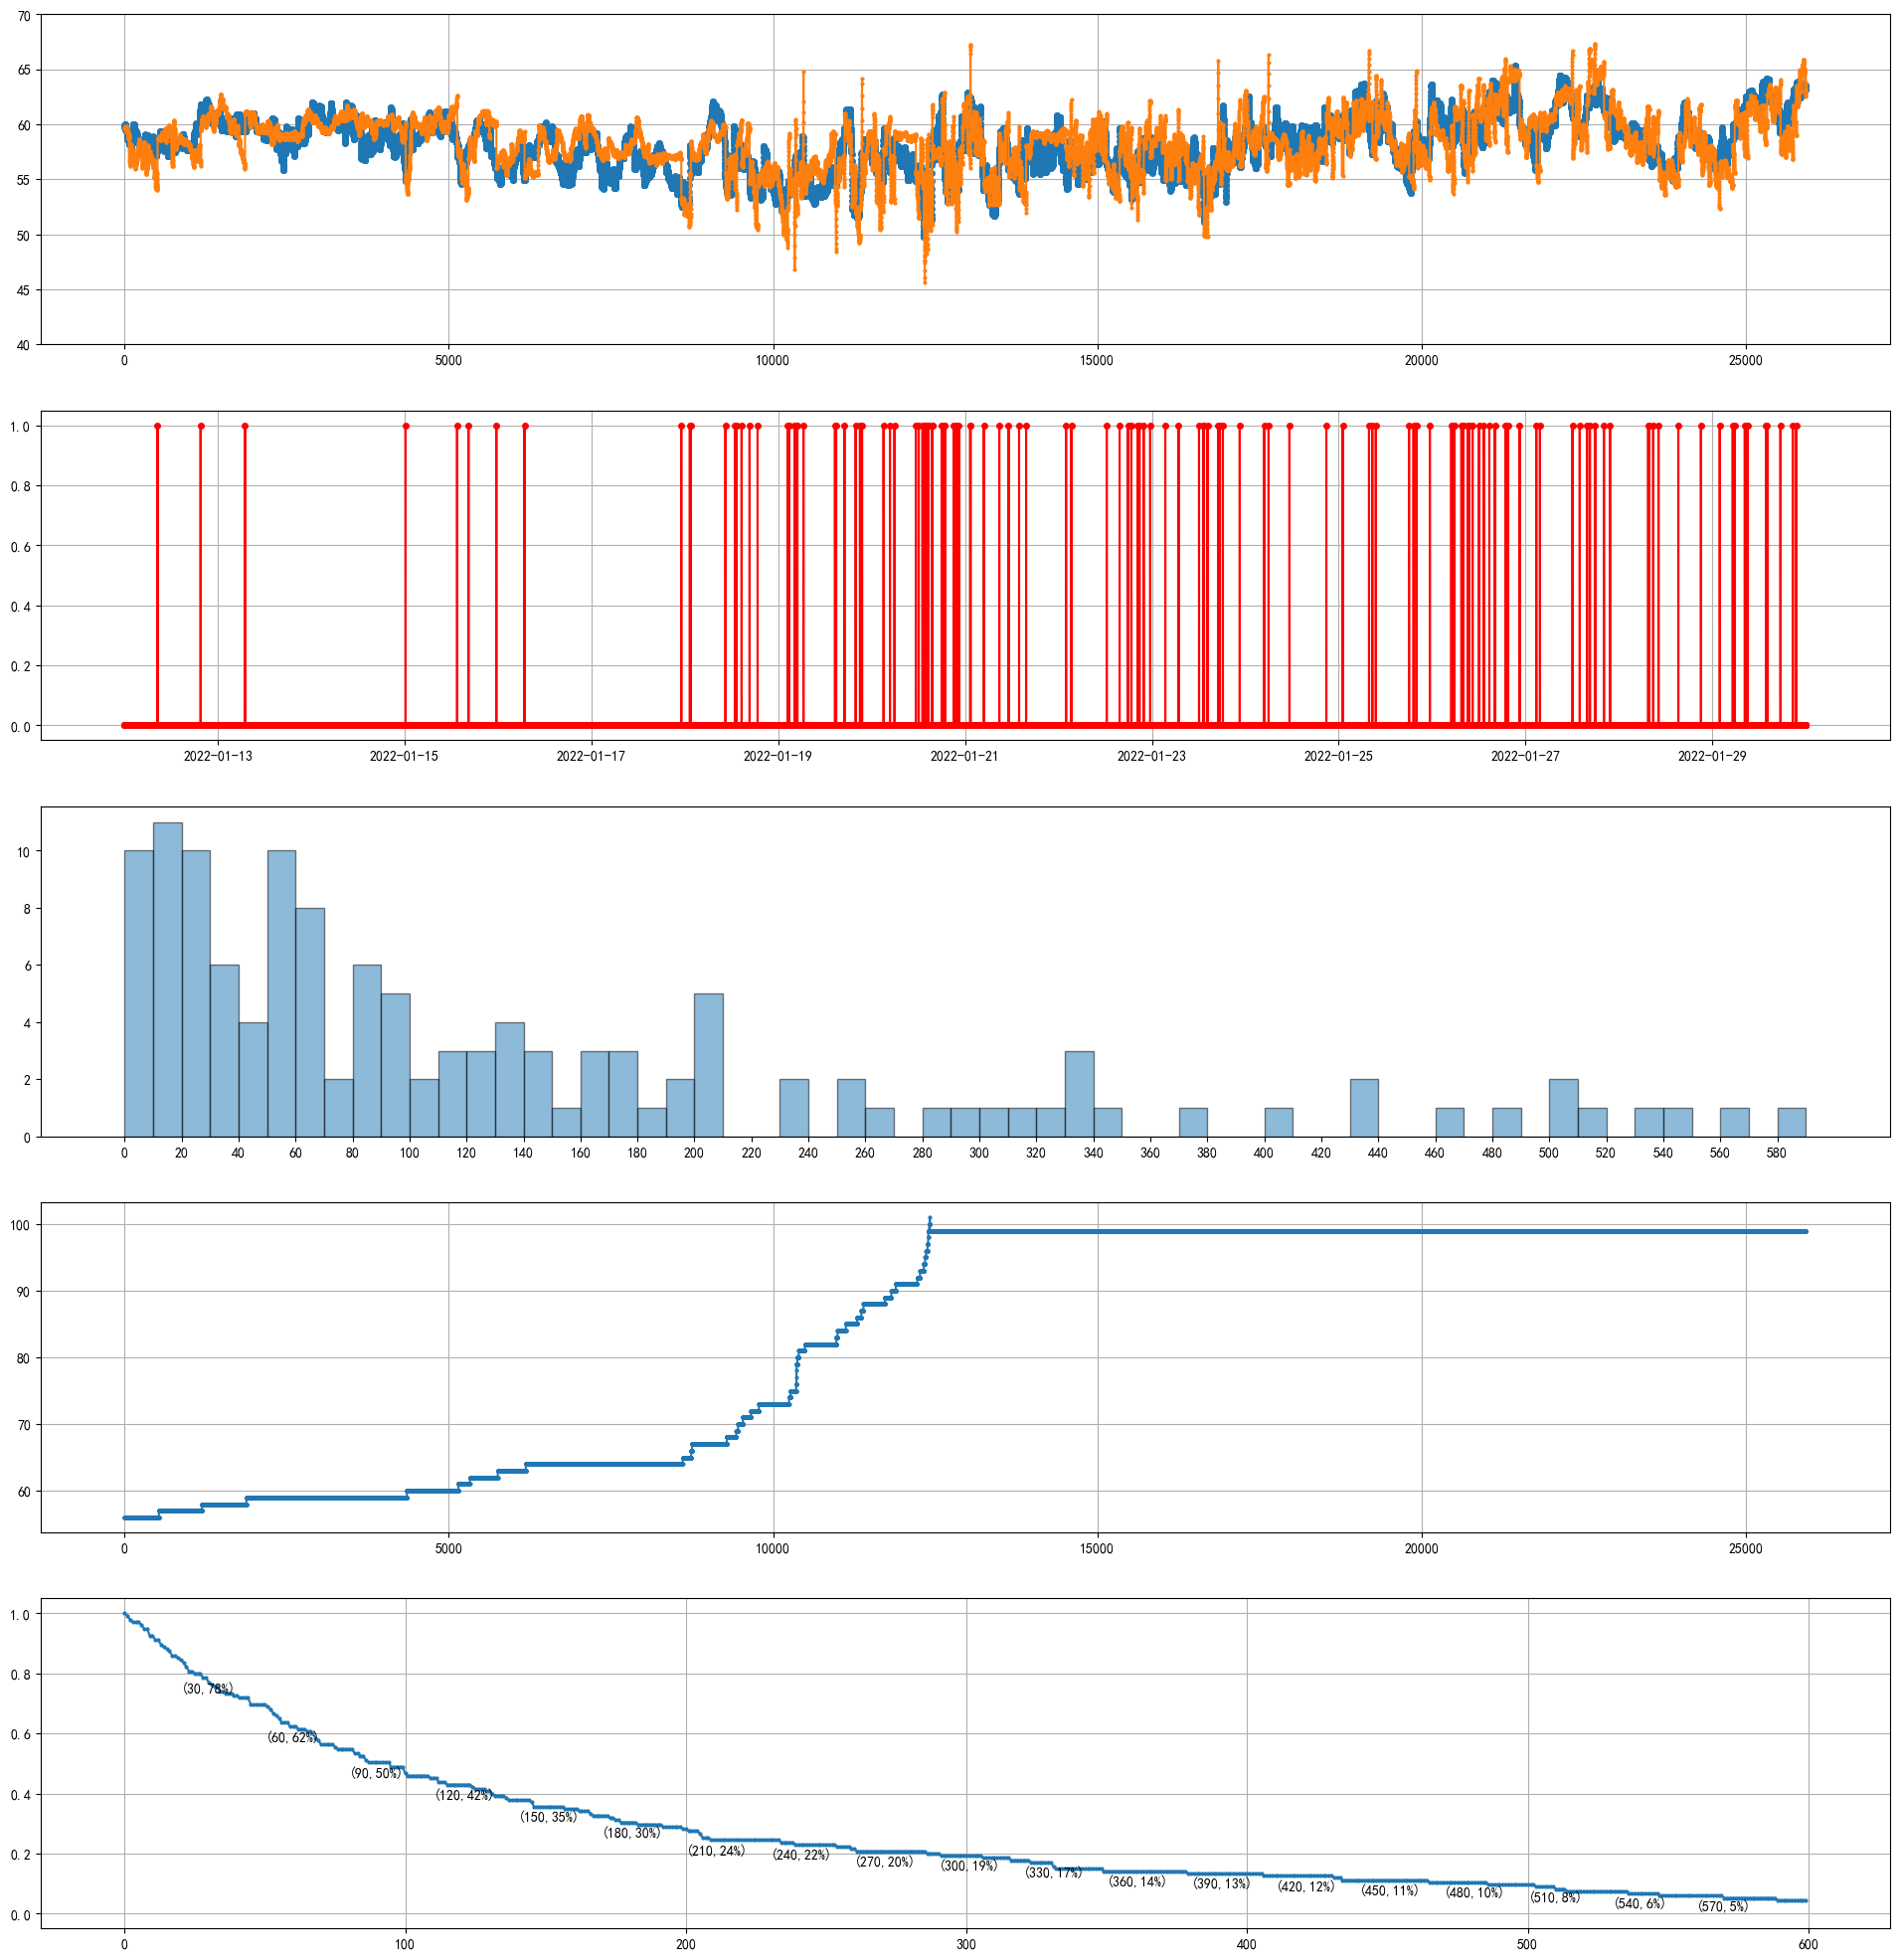

In [5]:
start_time = time.time()


################################################## 初始化
# 实验中所用的道德所有时间段选择 
ChosenRange_start = pd.Timestamp('2022-01-01 00:00:00')
ChosenRange_end = pd.Timestamp('2022-01-30 00:00:00')
# ChosenRange_end = pd.Timestamp('2022-01-04 00:00:00')
# 这之前的数据用于构建模型池,之后用于测试
test_start_ts = pd.Timestamp('2022-01-12 00:00:00')

data_Chosen = data_MeanFiltered.loc[ChosenRange_start:ChosenRange_end]
data1 = data_Chosen.copy()

# 特征选择
inputs = ['喂料', '二次风温','C1出口O2']
# inputs = ['喂料', '二次风温', 'F1234平均流量','C1出口O2','分解炉出口温度','高温风机转速', '窑头罩压力']
outputs = ['窑电流']

# 初始模型训练集长度
train_size_num = 22;

# MSE检测长度
MSE_check_size = 10

# MSE检测阈值
mse_check_threshold = 15

# 模型次数
degree_num = 1
ploy = PolynomialFeatures(degree=degree_num)

# 在线建模训练集的搜索参数
train_set_size_lb = 10
train_set_size_ub = 100
train_set_size_gap =2

# 在线建立一个模型
original_train_start_ts = test_start_ts - pd.Timedelta(minutes= train_size_num)
original_train_end_ts = test_start_ts 
original_model = RidgeRegressionModel(data1,original_train_start_ts,original_train_end_ts, degree_num )




# modeltype = 'ridge'
# rto_size = 60
# test_size_num = mean_window_size + rto_size;

########## 事先训练模型池


# 模型池用dataframe存放
# 存放了模型、模型训练集范围。MSE列用于存放MSE_check时候的数据。
model_pool = pd.DataFrame(data=[[original_model, original_train_start_ts , original_train_end_ts , None]], columns=['model','start_ts', 'end_ts','MSE'])

# 存放了模模型训练集范围、模型类别、模型参数
model_pool_original_trainingset = [
['2022-01-01 0:00', '2022-01-01 0:29','PolynomialRidge',2],
['2022-01-01 0:30', '2022-01-01 0:59','PolynomialRidge',2],
['2022-01-01 1:00', '2022-01-01 1:29','PolynomialRidge',2],
['2022-01-01 1:30', '2022-01-01 1:59','PolynomialRidge',2],
['2022-01-01 2:00', '2022-01-01 2:29','PolynomialRidge',2],
['2022-01-01 2:30', '2022-01-01 2:59','PolynomialRidge',2],
['2022-01-01 3:00', '2022-01-01 3:29','PolynomialRidge',2],
['2022-01-01 3:30', '2022-01-01 3:59','PolynomialRidge',2],
['2022-01-01 4:00', '2022-01-01 4:29','PolynomialRidge',2],
['2022-01-01 4:30', '2022-01-01 4:59','PolynomialRidge',2],
['2022-01-01 5:00', '2022-01-01 5:29','PolynomialRidge',2],
['2022-01-01 5:30', '2022-01-01 5:59','PolynomialRidge',2],
['2022-01-01 6:00', '2022-01-01 6:29','PolynomialRidge',2],
['2022-01-01 6:30', '2022-01-01 6:59','PolynomialRidge',2],
['2022-01-01 7:00', '2022-01-01 7:29','PolynomialRidge',2],
['2022-01-01 7:30', '2022-01-01 7:59','PolynomialRidge',2],
['2022-01-01 8:00', '2022-01-01 8:29','PolynomialRidge',2],
['2022-01-01 8:30', '2022-01-01 8:59','PolynomialRidge',2],
['2022-01-01 9:00', '2022-01-01 9:29','PolynomialRidge',2],
['2022-01-01 9:30', '2022-01-01 9:59','PolynomialRidge',2],
['2022-01-01 10:00', '2022-01-01 10:29','PolynomialRidge',2],
['2022-01-01 10:30', '2022-01-01 10:59','PolynomialRidge',2],
['2022-01-01 11:00', '2022-01-01 11:29','PolynomialRidge',2],
['2022-01-01 11:30', '2022-01-01 11:59','PolynomialRidge',2],
['2022-01-01 12:00', '2022-01-01 12:29','PolynomialRidge',2],
['2022-01-01 12:30', '2022-01-01 12:59','PolynomialRidge',2],
['2022-01-01 13:00', '2022-01-01 13:29','PolynomialRidge',2],
['2022-01-01 13:30', '2022-01-01 13:59','PolynomialRidge',2],
['2022-01-01 14:00', '2022-01-01 14:29','PolynomialRidge',2],
['2022-01-01 14:30', '2022-01-01 14:59','PolynomialRidge',2],
['2022-01-01 15:00', '2022-01-01 15:29','PolynomialRidge',2],
['2022-01-01 15:30', '2022-01-01 15:59','PolynomialRidge',2],
['2022-01-01 16:00', '2022-01-01 16:29','PolynomialRidge',2],
['2022-01-01 16:30', '2022-01-01 16:59','PolynomialRidge',2],
['2022-01-01 17:00', '2022-01-01 17:29','PolynomialRidge',2],
['2022-01-01 17:30', '2022-01-01 17:59','PolynomialRidge',2],
['2022-01-01 18:00', '2022-01-01 18:29','PolynomialRidge',2],
['2022-01-01 18:30', '2022-01-01 18:59','PolynomialRidge',2],
['2022-01-01 19:00', '2022-01-01 19:29','PolynomialRidge',2],
['2022-01-01 19:30', '2022-01-01 19:59','PolynomialRidge',2],
['2022-01-01 20:00', '2022-01-01 20:29','PolynomialRidge',2],
['2022-01-01 20:30', '2022-01-01 20:59','PolynomialRidge',2],
['2022-01-01 21:00', '2022-01-01 21:29','PolynomialRidge',2],
['2022-01-01 21:30', '2022-01-01 21:59','PolynomialRidge',2],
['2022-01-01 22:00', '2022-01-01 22:29','PolynomialRidge',2],
['2022-01-01 22:30', '2022-01-01 22:59','PolynomialRidge',2],
['2022-01-01 23:00', '2022-01-01 23:29','PolynomialRidge',2],
['2022-01-01 23:10', '2022-01-01 23:59','PolynomialRidge',2],
['2022-01-01 23:15', '2022-01-01 23:59','PolynomialRidge',2],
['2022-01-01 23:20', '2022-01-01 23:59','PolynomialRidge',2],
['2022-01-01 23:25', '2022-01-01 23:59','PolynomialRidge',2],
['2022-01-01 23:30', '2022-01-01 23:59','PolynomialRidge',2],
['2022-01-01 23:35', '2022-01-01 23:59','PolynomialRidge',2],
['2022-01-01 23:40', '2022-01-01 23:59','PolynomialRidge',2],
['2022-01-01 23:45', '2022-01-01 23:59','PolynomialRidge',2],
    
]

for trainingset_list in model_pool_original_trainingset: 
    start_ts = pd.Timestamp(trainingset_list[0])
    end_ts = pd.Timestamp(trainingset_list[1])
    if trainingset_list[2] == 'PolynomialRidge':
        model = RidgeRegressionModel(data1,start_ts,end_ts,degree_num)
    model_pool.loc[len(model_pool)] = [model, start_ts, end_ts, None]

# print(model_pool)

# 存放真实值
y_real = ydata(data1,test_start_ts ,ChosenRange_end) 

# 存放预测值
y_pred_list = []

# 存放历史状态
model_pool_len_list = []
mse_check_model_list = []

# 存放模型切换信息
model_change_time_list=[]

# 存放待检查模型
models_to_be_checked = pd.DataFrame(data=[[None, None , None , None]], columns=['model','start_ts', 'end_ts','MSE'])
models_to_be_checked = models_to_be_checked.drop(0, axis=0)   

current_model = original_model


##########################################################################
# 生成pd.timestamp数据的迭代对象
test_range_iteration = pd.date_range(start = test_start_ts,end = ChosenRange_end , freq='1min')
for time_now in test_range_iteration: 
    print('\n---------------',time_now,len(model_pool))
    model_pool_len_list.append(len(model_pool))
    
    
    if len(model_pool) > 100:
        model_pool = model_pool[2:]
    
   
    # 用当前模型预测当前数值
    X = Xdata(data1,time_now,time_now)
    y_pred = current_model.predict(ploy.fit_transform(X))
    y_pred_list.append(y_pred)

    mse_check_model = RidgeModelCheckMSE(current_model,data1,time_now,MSE_check_size)
    mse_check_model_list.append(mse_check_model)
    

    
    if not(models_to_be_checked.empty):    
        
        bool_a = (time_now - models_to_be_checked['end_ts'] == pd.Timedelta(minutes = mean_window_size + MSE_check_size))
        models_checking = models_to_be_checked[bool_a]
#         print(models_to_be_checked)
#         print(bool_a)
#         print(models_to_be_checked['end_ts']-time_now,'====',pd.Timedelta(minutes = mean_window_size + MSE_check_size))
        if not(models_checking.empty):  
            a_new_model,aa,bb = choose_model(models_checking,data1,time_now,MSE_check_size)
            model_pool.loc[len(model_pool)] = [current_model, aa, bb, None]
            models_to_be_checked = models_to_be_checked.drop(models_to_be_checked[bool_a].index)
    
    
    if mse_check_model>mse_check_threshold :
        
        model_change_time_list.append([time_now,1])

        
        # 选出模型池中最好的模型
        current_model,aa,bb = choose_model(model_pool,data1,time_now,MSE_check_size)
        del aa,bb
        

        # 在线构建新的模型  
        
        
        for  new_model_train_size in range(train_set_size_lb, train_set_size_ub, train_set_size_gap):
            new_model_start_ts = time_now - pd.Timedelta(minutes = new_model_train_size)
            new_model_end_ts = time_now 
            new_model = RidgeRegressionModel(data1,new_model_start_ts,new_model_end_ts, poly_degree = degree_num )                                                       
            models_to_be_checked.loc[len(models_to_be_checked)] = [new_model, new_model_start_ts, new_model_end_ts, None] 
            
    else:
        model_change_time_list.append([time_now,0])

   
        
#     if state == 1:
        
#         # 等待在线数据积累，用于检测新的模型
#         test_set_counter = test_set_counter + 1
#         mse_check_model= -2
#         mse_check_model_list.append(mse_check_model)
        
#         # 用当前模型预测当前数值
#         X = Xdata(data1,time_now,time_now)
#         y_pred = current_model.predict(ploy.fit_transform(X))
#         y_pred_list.append(y_pred)
        
#         # 在线数据积累到一定数量
#         if test_set_counter == MSE_check_size + mean_window_size:
#             mse_check_model = RidgeModelCheckMSE(current_model,data1,time_now,MSE_check_size)
            
#             # 如果当前模型适用
#             if mse_check_model <= mse_check_threshold:
#                 a_new_model,aa,bb = choose_model(model_pool,data1,time_now,MSE_check_size)
#                 model_pool.loc[len(model_pool)] = [current_model, aa, bb, None]
#                 state = 0
#                 continue
            
#             # 如果当前模型不适用
            
#             if mse_check_model > mse_check_threshold:
#                 current_model,aa,bb = choose_model(model_pool,data1,time_now,MSE_check_size)
#                 model_change_time_list.append([time_now,40]) # 表示使用的是在线模型
#                 model_pool.loc[len(model_pool)] = [current_model, aa, bb, None]
#                 state = 2
#                 continue
            
#     if state == 2:
#         # 用当前模型预测当前数值
#         X = Xdata(data1,time_now,time_now)
#         y_pred = current_model.predict(ploy.fit_transform(X))
#         y_pred_list.append(y_pred)
#         state =0;
    

            

data_result = pd.DataFrame( np.concatenate((np.array(y_real).reshape(-1,1), np.array(y_pred_list).reshape(-1,1)), axis=1),
                            columns=['真实值','预测值'] )
new_index = pd.date_range(test_start_ts , ChosenRange_end, freq='T')
data_result.set_index(new_index,inplace = True)
data_result.index.name = 'time'


data_model_change_result = pd.DataFrame(model_change_time_list,columns=['time','模型切换信息'])
data_model_change_result.set_index('time',inplace = True)


result = pd.merge(data_result,data_model_change_result,left_index=True, right_index=True,how = 'outer')
result['模型切换信息'].fillna(0, inplace=True)

time_str = str(int(time.time()))
file_name = 'result_' + time_str +'.csv'
# result.to_csv(file_name,encoding='gbk')



        
fig2,axes2 = plt.subplots(5,1,figsize=(24,25))
# 预测结果图
axes2[0].plot(y_real, marker='o',markersize=4)
axes2[0].plot(y_pred_list, marker='o',markersize=2)
axes2[0].set_ylim(40,70)

axes2[0].grid()

# 模型切换信息图
axes2[1].plot(result.loc[:,'模型切换信息'],marker='o',markersize=4, c ='r')  
axes2[1].grid()

# 单个模型延续时间图直方图
model_change_time_list3 = data_model_change_result[data_model_change_result['模型切换信息']==1].index 
model_change_time_list2 = []
model_change_time_list2.append( (  model_change_time_list3[0] - test_start_ts).total_seconds()/60.0   )
for i in range(len(model_change_time_list3)):
    if i == 0:
        continue;
    model_change_time_list2.append(     (model_change_time_list3[i]-model_change_time_list3[i-1]).total_seconds()/60.0        )
model_change_time_list2.append( ( ChosenRange_end - model_change_time_list[-1][0]).total_seconds()/60.0   )

max_bins = int(36000/60.0)
min_bins = int(0/60.0)
bins_gape = int(600/60.0)
bins = range(min_bins,max_bins, bins_gape)
axes2[2].hist(model_change_time_list2, bins=bins, alpha=0.5,edgecolor='black')
axes2[2].set_xticks(np.arange(min_bins,max_bins,bins_gape*2))

# 模型池大小图
axes2[3].plot(model_pool_len_list, marker='o',markersize=2)
axes2[3].grid()



# 单个模型延续时间图频率分布图

length = 600 
data_len = len(model_change_time_list2)
count_list = []
for i in range(length):
    count = 1 - sum(1 for x in model_change_time_list2 if x < i)/data_len
    count_list.append(count)
axes2[4].plot(count_list, marker='o',markersize=2)
axes2[4].grid()
axes2[4].set_ylim(-0.05,1.05)
axes2[4].set_xticks(np.arange(0,length+1, 100))
for i in range(30,length,30):
    axes2[4].text(i-10, count_list[i-1]-0.05, '({},{}%)'.format(i,int(count_list[i-1]*100)))


end_time = time.time()
run_time = end_time - start_time
print('======================================================')
print('当前输入特征', inputs)
print('当前MSE阈值：{} '.format(mse_check_threshold))
print('程序运行了：{} 秒'.format(run_time))

print('总切换次数：{0} '.format(len(model_change_time_list3)))

average_model_change_time = (ChosenRange_end - test_start_ts).total_seconds() / (len(model_change_time_list3)+1)
print('平均模型维持时间：{0} 秒，即 {1} 小时'.format(average_model_change_time, average_model_change_time/3600.0))

mse_result = mean_squared_error(result['真实值'], result['预测值'])
print('MSE: {0}'.format(mse_result))

# average_model_change_time = sum(model_change_time_list2)/len(model_change_time_list2)
# print('平均切换时间：{0} 分钟，即 {1} 小时'.format(average_model_change_time, average_model_change_time/60.0))
# print('平均切换时间：{0} 秒，即 {1} 小时'.format(sum(model_change_time_list2)/len(model_change_time_list2)))

